In [1]:
import torch
import pandas as pd
from collections import Counter
import music21

In [2]:
torch.cuda.is_available()

True

# TO IMPROVE:

Data:
- I need to take everypart of the music in account => piano both hand etc
    - improve data loading
    - create one model of each parts of the song (training model by instrument?)
    - remove flat song 

# Load data

In [47]:
df = pd.read_csv(r'D:\Documents\Music generation project\data\df\ff_music_df.csv')
df = df.dropna()
df.head()

,music
0,4.9 E2 4.9 4.9 4.9 4.9 4.9 4.9 4.9 11.4 4.9 11...
1,C5 E4 C2 C5 E4 C2 G4 G4 C5 C5 D5 10.2 B-1 D5 1...
2,0.4 0.4 0.5 0.5 0.4 0.4 0.2 C5 0.2 F5 G5 0.4 0...
4,F3 C4 4.9 E4 C4 2.5 E4 C4 9.0 E4 C4 F3 C4 4.9 ...
5,C6 A3 E4 C6 F4 E4 C6 A3 E4 C6 F4 E4 E5 A3 E4 E...


In [48]:
#test => add EOS AND SOS token
df['music'] = 'SOS ' + df['music'] + ' EOS'
df.head()

,music
0,SOS 4.9 E2 4.9 4.9 4.9 4.9 4.9 4.9 4.9 11.4 4....
1,SOS C5 E4 C2 C5 E4 C2 G4 G4 C5 C5 D5 10.2 B-1 ...
2,SOS 0.4 0.4 0.5 0.5 0.4 0.4 0.2 C5 0.2 F5 G5 0...
4,SOS F3 C4 4.9 E4 C4 2.5 E4 C4 9.0 E4 C4 F3 C4 ...
5,SOS C6 A3 E4 C6 F4 E4 C6 A3 E4 C6 F4 E4 E5 A3 ...


In [33]:
a_song = converter.parse(r'D:\Documents\Music generation project\data\ff_midi\electric_de_chocobo.mid')
a_song.show('midi')

In [49]:
mylist = df['music'].to_list()
mylist = [' '.join(str(i) for i in mylist)]
for i in mylist: #sanity check
    print(i)

SOS 4.9 E2 4.9 4.9 4.9 4.9 4.9 4.9 4.9 11.4 4.9 11.4 4.9 4.9 4.9 4.9 4.9 0.4 E2 4.9 0.4 4.9 4.9 4.9 4.9 4.9 9.2 4.9 9.2 9.2 4.9 4.9 4.9 4.9 4.9 4.9 E2 4.9 4.9 4.9 4.9 4.9 E5 F5 G#5 A5 4.9 4.9 5.11 4.9 5.11 4.9 4.9 4.9 E5 F5 G#5 A5 4.9 4.9 9.0 E2 4.9 9.0 4.9 4.9 4.9 E5 F5 G#5 A5 4.9 4.9 11.2 4.9 11.2 11.2 4.9 4.9 4.9 E5 F5 G#5 A5 4.9 4.9 3.7.11 E-2 3.7.11 B2 G2 1.5.9 F#2 1.5.9 3.7.11 E-2 3.7.11 G2 B2 E-3 1.5.9 G#2 1.5.9 1.5.9 F3 F2 F2 F2 F2 F2 4.9 E5 4.9 C5 4.9 A5 4.9 5.9 F5 5.9 C5 5.9 A5 5.9 4.9 E5 4.9 C5 4.9 A5 4.9 F5 5.9 C5 5.9 E5 5.9 D5 5.9 E5 4.9 E-5 4.9 B5 4.9 4.9 A5 5.9 5.9 5.9 5.9 4.9 4.9 4.9 4.9 5.9 5.9 5.9 5.9 B4 4.9 A4 4.9 E5 4.9 4.9 E-5 5.9 5.9 5.9 5.9 4.9 4.9 4.9 4.9 5.9 5.9 5.9 5.9 E5 4 E-5 C6 E5 5 E-5 B5 E5 6 E-5 C6 A5 5 A4 4 C5 E5 F5 E5 5 C5 A4 C5 A4 6 C5 E5 F#5 E5 5 C5 A4 C5 A4 4 C5 E5 F5 E5 5 C5 A4 C5 A4 6 C5 E5 F#5 E5 5 C5 A4 C5 A4 A2 C5 E5 F5 A2 E5 A2 C5 B4 C5 A4 A2 F4 E4 F4 A2 E4 A2 C4 B3 C4 E5 4.9 B5 4.9 A5 4.9 G5 F5 4.9 4.9 E5 5.10 F5 G5 D5 5.10 F5 5.10 E5 5.10 D5

In [50]:
from torchtext.data import Field, BPTTIterator, TabularDataset, Dataset, Example

#prepare the field

tokenize = lambda x: x.split()

TEXT = Field(sequential = True, tokenize = tokenize, fix_length = None)

datafields = [("text",TEXT)]

#loading the dataset

train_examples = [Example.fromlist(mylist, datafields)] 
train_data = Dataset(train_examples, datafields) #define a dataset composed of examples along with its field

#build the vocab

TEXT.build_vocab(train_data)

vocab = TEXT.vocab

#create the iterator object

train_iter = BPTTIterator(train_data, batch_size=10, bptt_len=5)

#if bptt_len = 3:

#With great power -> great power comes
#comes great responsibility -> great responsibility !


In [51]:
#sanity check

train_data[0].text[:]

['SOS',
 '4.9',
 'E2',
 '4.9',
 '4.9',
 '4.9',
 '4.9',
 '4.9',
 '4.9',
 '4.9',
 '11.4',
 '4.9',
 '11.4',
 '4.9',
 '4.9',
 '4.9',
 '4.9',
 '4.9',
 '0.4',
 'E2',
 '4.9',
 '0.4',
 '4.9',
 '4.9',
 '4.9',
 '4.9',
 '4.9',
 '9.2',
 '4.9',
 '9.2',
 '9.2',
 '4.9',
 '4.9',
 '4.9',
 '4.9',
 '4.9',
 '4.9',
 'E2',
 '4.9',
 '4.9',
 '4.9',
 '4.9',
 '4.9',
 'E5',
 'F5',
 'G#5',
 'A5',
 '4.9',
 '4.9',
 '5.11',
 '4.9',
 '5.11',
 '4.9',
 '4.9',
 '4.9',
 'E5',
 'F5',
 'G#5',
 'A5',
 '4.9',
 '4.9',
 '9.0',
 'E2',
 '4.9',
 '9.0',
 '4.9',
 '4.9',
 '4.9',
 'E5',
 'F5',
 'G#5',
 'A5',
 '4.9',
 '4.9',
 '11.2',
 '4.9',
 '11.2',
 '11.2',
 '4.9',
 '4.9',
 '4.9',
 'E5',
 'F5',
 'G#5',
 'A5',
 '4.9',
 '4.9',
 '3.7.11',
 'E-2',
 '3.7.11',
 'B2',
 'G2',
 '1.5.9',
 'F#2',
 '1.5.9',
 '3.7.11',
 'E-2',
 '3.7.11',
 'G2',
 'B2',
 'E-3',
 '1.5.9',
 'G#2',
 '1.5.9',
 '1.5.9',
 'F3',
 'F2',
 'F2',
 'F2',
 'F2',
 'F2',
 '4.9',
 'E5',
 '4.9',
 'C5',
 '4.9',
 'A5',
 '4.9',
 '5.9',
 'F5',
 '5.9',
 'C5',
 '5.9',
 'A5',
 '5.9',
 '4

# J'allume J'allume J'allume 

## THE MODEL 

In [52]:
import torch
from torch import nn


class LSTMClassifier(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, dropout, embedding_dim, num_layers):
        super(LSTMClassifier, self).__init__()
        self.input_size = input_size
        self.num_layers = num_layers
        
        self.emb = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers = num_layers, dropout = dropout)
        self.fc = nn.Linear(self.input_size, output_size)
        #self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        emb = self.emb(x)
        lstm_out, state = self.lstm(emb)
        logits = self.fc(lstm_out)
        return  logits, state
    
    def initHidden(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.input_size).cuda(),
                torch.zeros(self.num_layers, sequence_length, self.input_size).cuda())
        

In [53]:
import numpy as np

def train(model, iterator, criterion, epoch):
    total_loss, total_correct, total_prediction = 0.0, 0.0, 0.0
    model.train()
    
    for epoch in range(epoch):
    
        for batch, x in enumerate(iterator): 
            optimizer.zero_grad()
            
            #print(x.text)
            #print(x.target)

            batch_text = x.text.cuda()
            batch_target = x.target.cuda()
            
            #print(batch_text)

            result, (state_h, state_c) = model(batch_text)
            loss = criterion(result.view(-1, result.shape[-1]), batch_target.view(-1))

            loss.backward()
            optimizer.step()

            print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })


In [54]:
from torch import optim

input_size = len(TEXT.vocab)
hidden_size = len(TEXT.vocab)
output_size= len(TEXT.vocab) #we want a probability of each word (note)
dropout = 0.2
embedding_dim = 128
num_layers = 3
epoch = 10

model = LSTMClassifier(input_size, hidden_size, output_size, dropout, embedding_dim, num_layers)
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.cuda()
criterion.cuda()

train(model, train_iter, criterion, epoch)


{'epoch': 0, 'batch': 0, 'loss': 5.8887457847595215}
{'epoch': 0, 'batch': 1, 'loss': 5.873467445373535}
{'epoch': 0, 'batch': 2, 'loss': 5.848850250244141}
{'epoch': 0, 'batch': 3, 'loss': 5.842541694641113}
{'epoch': 0, 'batch': 4, 'loss': 5.804193496704102}
{'epoch': 0, 'batch': 5, 'loss': 5.814154148101807}
{'epoch': 0, 'batch': 6, 'loss': 5.708654403686523}
{'epoch': 0, 'batch': 7, 'loss': 5.576317310333252}
{'epoch': 0, 'batch': 8, 'loss': 5.664471626281738}
{'epoch': 0, 'batch': 9, 'loss': 5.503328323364258}
{'epoch': 0, 'batch': 10, 'loss': 5.196409702301025}
{'epoch': 0, 'batch': 11, 'loss': 5.198833465576172}
{'epoch': 0, 'batch': 12, 'loss': 4.95241641998291}
{'epoch': 0, 'batch': 13, 'loss': 4.9761433601379395}
{'epoch': 0, 'batch': 14, 'loss': 4.885735988616943}
{'epoch': 0, 'batch': 15, 'loss': 4.885340213775635}
{'epoch': 0, 'batch': 16, 'loss': 4.575618267059326}
{'epoch': 0, 'batch': 17, 'loss': 5.399336338043213}
{'epoch': 0, 'batch': 18, 'loss': 5.492376804351807}
{'

{'epoch': 0, 'batch': 164, 'loss': 4.5785908699035645}
{'epoch': 0, 'batch': 165, 'loss': 4.736467361450195}
{'epoch': 0, 'batch': 166, 'loss': 4.646971225738525}
{'epoch': 0, 'batch': 167, 'loss': 4.682009696960449}
{'epoch': 0, 'batch': 168, 'loss': 4.675281524658203}
{'epoch': 0, 'batch': 169, 'loss': 4.817419052124023}
{'epoch': 0, 'batch': 170, 'loss': 4.849401473999023}
{'epoch': 0, 'batch': 171, 'loss': 4.7955169677734375}
{'epoch': 0, 'batch': 172, 'loss': 4.6789445877075195}
{'epoch': 0, 'batch': 173, 'loss': 4.588979244232178}
{'epoch': 0, 'batch': 174, 'loss': 4.593316555023193}
{'epoch': 0, 'batch': 175, 'loss': 4.686347007751465}
{'epoch': 0, 'batch': 176, 'loss': 4.52485466003418}
{'epoch': 0, 'batch': 177, 'loss': 4.5916361808776855}
{'epoch': 0, 'batch': 178, 'loss': 4.780186653137207}
{'epoch': 0, 'batch': 179, 'loss': 4.584151744842529}
{'epoch': 0, 'batch': 180, 'loss': 4.4973015785217285}
{'epoch': 0, 'batch': 181, 'loss': 4.389082431793213}
{'epoch': 0, 'batch': 18

{'epoch': 0, 'batch': 320, 'loss': 4.992302894592285}
{'epoch': 0, 'batch': 321, 'loss': 4.948742866516113}
{'epoch': 0, 'batch': 322, 'loss': 4.934861183166504}
{'epoch': 0, 'batch': 323, 'loss': 4.888635635375977}
{'epoch': 0, 'batch': 324, 'loss': 4.874317646026611}
{'epoch': 0, 'batch': 325, 'loss': 4.9414591789245605}
{'epoch': 0, 'batch': 326, 'loss': 4.931663513183594}
{'epoch': 0, 'batch': 327, 'loss': 4.723299980163574}
{'epoch': 0, 'batch': 328, 'loss': 4.552511215209961}
{'epoch': 0, 'batch': 329, 'loss': 4.593198776245117}
{'epoch': 0, 'batch': 330, 'loss': 5.0063700675964355}
{'epoch': 0, 'batch': 331, 'loss': 4.7945876121521}
{'epoch': 0, 'batch': 332, 'loss': 4.642261981964111}
{'epoch': 0, 'batch': 333, 'loss': 5.014842510223389}
{'epoch': 0, 'batch': 334, 'loss': 4.494848728179932}
{'epoch': 0, 'batch': 335, 'loss': 4.4573283195495605}
{'epoch': 0, 'batch': 336, 'loss': 4.761806488037109}
{'epoch': 0, 'batch': 337, 'loss': 4.626195907592773}
{'epoch': 0, 'batch': 338, 

{'epoch': 0, 'batch': 484, 'loss': 4.788985729217529}
{'epoch': 0, 'batch': 485, 'loss': 4.254968166351318}
{'epoch': 0, 'batch': 486, 'loss': 4.008131504058838}
{'epoch': 0, 'batch': 487, 'loss': 4.311763763427734}
{'epoch': 0, 'batch': 488, 'loss': 4.836068630218506}
{'epoch': 0, 'batch': 489, 'loss': 4.307069778442383}
{'epoch': 0, 'batch': 490, 'loss': 4.4131364822387695}
{'epoch': 0, 'batch': 491, 'loss': 4.681049823760986}
{'epoch': 0, 'batch': 492, 'loss': 4.883162021636963}
{'epoch': 0, 'batch': 493, 'loss': 4.235588550567627}
{'epoch': 0, 'batch': 494, 'loss': 3.9375760555267334}
{'epoch': 0, 'batch': 495, 'loss': 4.128900527954102}
{'epoch': 0, 'batch': 496, 'loss': 4.207082748413086}
{'epoch': 0, 'batch': 497, 'loss': 4.491252422332764}
{'epoch': 0, 'batch': 498, 'loss': 3.9754416942596436}
{'epoch': 0, 'batch': 499, 'loss': 4.149049282073975}
{'epoch': 0, 'batch': 500, 'loss': 4.085417747497559}
{'epoch': 0, 'batch': 501, 'loss': 4.005245208740234}
{'epoch': 0, 'batch': 502

{'epoch': 0, 'batch': 647, 'loss': 4.291553497314453}
{'epoch': 0, 'batch': 648, 'loss': 4.5318708419799805}
{'epoch': 0, 'batch': 649, 'loss': 5.081058979034424}
{'epoch': 0, 'batch': 650, 'loss': 4.608703136444092}
{'epoch': 0, 'batch': 651, 'loss': 4.507042407989502}
{'epoch': 0, 'batch': 652, 'loss': 4.427156448364258}
{'epoch': 0, 'batch': 653, 'loss': 4.105477333068848}
{'epoch': 0, 'batch': 654, 'loss': 4.343203544616699}
{'epoch': 0, 'batch': 655, 'loss': 4.476752758026123}
{'epoch': 0, 'batch': 656, 'loss': 4.395659923553467}
{'epoch': 0, 'batch': 657, 'loss': 4.572592735290527}
{'epoch': 0, 'batch': 658, 'loss': 4.483205318450928}
{'epoch': 0, 'batch': 659, 'loss': 4.611727714538574}
{'epoch': 0, 'batch': 660, 'loss': 4.593352794647217}
{'epoch': 0, 'batch': 661, 'loss': 4.138261795043945}
{'epoch': 0, 'batch': 662, 'loss': 4.1723952293396}
{'epoch': 0, 'batch': 663, 'loss': 4.205535411834717}
{'epoch': 0, 'batch': 664, 'loss': 4.060885429382324}
{'epoch': 0, 'batch': 665, 'l

{'epoch': 0, 'batch': 811, 'loss': 4.490167617797852}
{'epoch': 0, 'batch': 812, 'loss': 4.1962714195251465}
{'epoch': 0, 'batch': 813, 'loss': 4.479008197784424}
{'epoch': 0, 'batch': 814, 'loss': 4.309370040893555}
{'epoch': 0, 'batch': 815, 'loss': 4.196981906890869}
{'epoch': 0, 'batch': 816, 'loss': 4.220129489898682}
{'epoch': 0, 'batch': 817, 'loss': 4.424199104309082}
{'epoch': 0, 'batch': 818, 'loss': 4.160882472991943}
{'epoch': 0, 'batch': 819, 'loss': 4.422622203826904}
{'epoch': 0, 'batch': 820, 'loss': 4.24949312210083}
{'epoch': 0, 'batch': 821, 'loss': 4.13203239440918}
{'epoch': 0, 'batch': 822, 'loss': 4.297787666320801}
{'epoch': 0, 'batch': 823, 'loss': 4.203725814819336}
{'epoch': 0, 'batch': 824, 'loss': 3.938777446746826}
{'epoch': 0, 'batch': 825, 'loss': 4.244708061218262}
{'epoch': 0, 'batch': 826, 'loss': 4.151381969451904}
{'epoch': 0, 'batch': 827, 'loss': 4.368724346160889}
{'epoch': 0, 'batch': 828, 'loss': 4.561358451843262}
{'epoch': 0, 'batch': 829, 'l

{'epoch': 0, 'batch': 978, 'loss': 3.724987506866455}
{'epoch': 0, 'batch': 979, 'loss': 3.6615374088287354}
{'epoch': 0, 'batch': 980, 'loss': 3.7669858932495117}
{'epoch': 0, 'batch': 981, 'loss': 4.12794303894043}
{'epoch': 0, 'batch': 982, 'loss': 4.069803237915039}
{'epoch': 0, 'batch': 983, 'loss': 4.312542915344238}
{'epoch': 0, 'batch': 984, 'loss': 4.143709659576416}
{'epoch': 0, 'batch': 985, 'loss': 4.339573860168457}
{'epoch': 0, 'batch': 986, 'loss': 4.113009452819824}
{'epoch': 0, 'batch': 987, 'loss': 4.1194539070129395}
{'epoch': 0, 'batch': 988, 'loss': 4.0804643630981445}
{'epoch': 0, 'batch': 989, 'loss': 3.9926178455352783}
{'epoch': 0, 'batch': 990, 'loss': 4.034815788269043}
{'epoch': 0, 'batch': 991, 'loss': 3.854959487915039}
{'epoch': 0, 'batch': 992, 'loss': 3.6964845657348633}
{'epoch': 0, 'batch': 993, 'loss': 4.226198196411133}
{'epoch': 0, 'batch': 994, 'loss': 3.776097297668457}
{'epoch': 0, 'batch': 995, 'loss': 3.972144365310669}
{'epoch': 0, 'batch': 9

{'epoch': 1, 'batch': 13, 'loss': 3.8226864337921143}
{'epoch': 1, 'batch': 14, 'loss': 3.744997024536133}
{'epoch': 1, 'batch': 15, 'loss': 3.7972567081451416}
{'epoch': 1, 'batch': 16, 'loss': 3.898303508758545}
{'epoch': 1, 'batch': 17, 'loss': 4.360655307769775}
{'epoch': 1, 'batch': 18, 'loss': 4.481956958770752}
{'epoch': 1, 'batch': 19, 'loss': 4.261301517486572}
{'epoch': 1, 'batch': 20, 'loss': 4.308060646057129}
{'epoch': 1, 'batch': 21, 'loss': 4.025360107421875}
{'epoch': 1, 'batch': 22, 'loss': 3.9234704971313477}
{'epoch': 1, 'batch': 23, 'loss': 3.8374383449554443}
{'epoch': 1, 'batch': 24, 'loss': 3.5120420455932617}
{'epoch': 1, 'batch': 25, 'loss': 3.8383889198303223}
{'epoch': 1, 'batch': 26, 'loss': 3.6490983963012695}
{'epoch': 1, 'batch': 27, 'loss': 3.748244524002075}
{'epoch': 1, 'batch': 28, 'loss': 3.77669095993042}
{'epoch': 1, 'batch': 29, 'loss': 3.9278008937835693}
{'epoch': 1, 'batch': 30, 'loss': 3.8234751224517822}
{'epoch': 1, 'batch': 31, 'loss': 3.77

{'epoch': 1, 'batch': 181, 'loss': 3.8490331172943115}
{'epoch': 1, 'batch': 182, 'loss': 3.7544686794281006}
{'epoch': 1, 'batch': 183, 'loss': 3.8190722465515137}
{'epoch': 1, 'batch': 184, 'loss': 3.7381210327148438}
{'epoch': 1, 'batch': 185, 'loss': 3.975876808166504}
{'epoch': 1, 'batch': 186, 'loss': 4.054455757141113}
{'epoch': 1, 'batch': 187, 'loss': 4.024288177490234}
{'epoch': 1, 'batch': 188, 'loss': 4.149412631988525}
{'epoch': 1, 'batch': 189, 'loss': 4.068143844604492}
{'epoch': 1, 'batch': 190, 'loss': 3.9265220165252686}
{'epoch': 1, 'batch': 191, 'loss': 4.343135356903076}
{'epoch': 1, 'batch': 192, 'loss': 4.000993728637695}
{'epoch': 1, 'batch': 193, 'loss': 4.372777938842773}
{'epoch': 1, 'batch': 194, 'loss': 3.9096786975860596}
{'epoch': 1, 'batch': 195, 'loss': 3.599947929382324}
{'epoch': 1, 'batch': 196, 'loss': 4.13775634765625}
{'epoch': 1, 'batch': 197, 'loss': 4.182213306427002}
{'epoch': 1, 'batch': 198, 'loss': 4.295767307281494}
{'epoch': 1, 'batch': 1

{'epoch': 1, 'batch': 349, 'loss': 4.1036376953125}
{'epoch': 1, 'batch': 350, 'loss': 3.878997802734375}
{'epoch': 1, 'batch': 351, 'loss': 3.897334337234497}
{'epoch': 1, 'batch': 352, 'loss': 4.1394362449646}
{'epoch': 1, 'batch': 353, 'loss': 3.838264226913452}
{'epoch': 1, 'batch': 354, 'loss': 4.211077690124512}
{'epoch': 1, 'batch': 355, 'loss': 4.41903829574585}
{'epoch': 1, 'batch': 356, 'loss': 4.215023517608643}
{'epoch': 1, 'batch': 357, 'loss': 4.406736850738525}
{'epoch': 1, 'batch': 358, 'loss': 4.196719169616699}
{'epoch': 1, 'batch': 359, 'loss': 4.050494194030762}
{'epoch': 1, 'batch': 360, 'loss': 4.19398307800293}
{'epoch': 1, 'batch': 361, 'loss': 4.303630352020264}
{'epoch': 1, 'batch': 362, 'loss': 4.392641544342041}
{'epoch': 1, 'batch': 363, 'loss': 4.345156669616699}
{'epoch': 1, 'batch': 364, 'loss': 4.345991611480713}
{'epoch': 1, 'batch': 365, 'loss': 4.488697528839111}
{'epoch': 1, 'batch': 366, 'loss': 4.145510196685791}
{'epoch': 1, 'batch': 367, 'loss':

{'epoch': 1, 'batch': 517, 'loss': 3.6729118824005127}
{'epoch': 1, 'batch': 518, 'loss': 3.9123733043670654}
{'epoch': 1, 'batch': 519, 'loss': 3.715101718902588}
{'epoch': 1, 'batch': 520, 'loss': 3.7275009155273438}
{'epoch': 1, 'batch': 521, 'loss': 3.7506911754608154}
{'epoch': 1, 'batch': 522, 'loss': 3.8237814903259277}
{'epoch': 1, 'batch': 523, 'loss': 3.542609930038452}
{'epoch': 1, 'batch': 524, 'loss': 4.145871162414551}
{'epoch': 1, 'batch': 525, 'loss': 4.050410270690918}
{'epoch': 1, 'batch': 526, 'loss': 3.790720224380493}
{'epoch': 1, 'batch': 527, 'loss': 3.788745641708374}
{'epoch': 1, 'batch': 528, 'loss': 3.8364439010620117}
{'epoch': 1, 'batch': 529, 'loss': 4.162912845611572}
{'epoch': 1, 'batch': 530, 'loss': 4.047971725463867}
{'epoch': 1, 'batch': 531, 'loss': 4.070852756500244}
{'epoch': 1, 'batch': 532, 'loss': 4.124297618865967}
{'epoch': 1, 'batch': 533, 'loss': 4.111288070678711}
{'epoch': 1, 'batch': 534, 'loss': 4.374029159545898}
{'epoch': 1, 'batch': 

{'epoch': 1, 'batch': 684, 'loss': 3.6599643230438232}
{'epoch': 1, 'batch': 685, 'loss': 3.725130558013916}
{'epoch': 1, 'batch': 686, 'loss': 3.7186479568481445}
{'epoch': 1, 'batch': 687, 'loss': 3.5889711380004883}
{'epoch': 1, 'batch': 688, 'loss': 3.9070065021514893}
{'epoch': 1, 'batch': 689, 'loss': 3.6124536991119385}
{'epoch': 1, 'batch': 690, 'loss': 3.481687068939209}
{'epoch': 1, 'batch': 691, 'loss': 3.4659736156463623}
{'epoch': 1, 'batch': 692, 'loss': 3.769167900085449}
{'epoch': 1, 'batch': 693, 'loss': 3.6721503734588623}
{'epoch': 1, 'batch': 694, 'loss': 3.6505541801452637}
{'epoch': 1, 'batch': 695, 'loss': 3.6577863693237305}
{'epoch': 1, 'batch': 696, 'loss': 3.7746713161468506}
{'epoch': 1, 'batch': 697, 'loss': 3.6789638996124268}
{'epoch': 1, 'batch': 698, 'loss': 3.722501277923584}
{'epoch': 1, 'batch': 699, 'loss': 3.901495933532715}
{'epoch': 1, 'batch': 700, 'loss': 4.071805477142334}
{'epoch': 1, 'batch': 701, 'loss': 4.03265905380249}
{'epoch': 1, 'batc

{'epoch': 1, 'batch': 850, 'loss': 4.311417102813721}
{'epoch': 1, 'batch': 851, 'loss': 4.498713493347168}
{'epoch': 1, 'batch': 852, 'loss': 3.7043709754943848}
{'epoch': 1, 'batch': 853, 'loss': 3.3628506660461426}
{'epoch': 1, 'batch': 854, 'loss': 4.014760494232178}
{'epoch': 1, 'batch': 855, 'loss': 4.3257670402526855}
{'epoch': 1, 'batch': 856, 'loss': 4.392500400543213}
{'epoch': 1, 'batch': 857, 'loss': 4.075104236602783}
{'epoch': 1, 'batch': 858, 'loss': 4.3397698402404785}
{'epoch': 1, 'batch': 859, 'loss': 4.411492824554443}
{'epoch': 1, 'batch': 860, 'loss': 4.579886436462402}
{'epoch': 1, 'batch': 861, 'loss': 4.243517875671387}
{'epoch': 1, 'batch': 862, 'loss': 4.193500518798828}
{'epoch': 1, 'batch': 863, 'loss': 3.7908968925476074}
{'epoch': 1, 'batch': 864, 'loss': 3.8871853351593018}
{'epoch': 1, 'batch': 865, 'loss': 3.9252572059631348}
{'epoch': 1, 'batch': 866, 'loss': 3.8971590995788574}
{'epoch': 1, 'batch': 867, 'loss': 4.120149612426758}
{'epoch': 1, 'batch'

{'epoch': 1, 'batch': 1018, 'loss': 3.8134167194366455}
{'epoch': 1, 'batch': 1019, 'loss': 4.157708644866943}
{'epoch': 1, 'batch': 1020, 'loss': 3.598060369491577}
{'epoch': 1, 'batch': 1021, 'loss': 3.911438226699829}
{'epoch': 1, 'batch': 1022, 'loss': 3.787937879562378}
{'epoch': 1, 'batch': 1023, 'loss': 4.076102256774902}
{'epoch': 1, 'batch': 1024, 'loss': 4.012718200683594}
{'epoch': 1, 'batch': 1025, 'loss': 4.155954360961914}
{'epoch': 1, 'batch': 1026, 'loss': 4.264420032501221}
{'epoch': 1, 'batch': 1027, 'loss': 3.7867889404296875}
{'epoch': 1, 'batch': 1028, 'loss': 3.8885607719421387}
{'epoch': 1, 'batch': 1029, 'loss': 3.8093085289001465}
{'epoch': 1, 'batch': 1030, 'loss': 3.7130544185638428}
{'epoch': 1, 'batch': 1031, 'loss': 4.085411548614502}
{'epoch': 1, 'batch': 1032, 'loss': 3.97705078125}
{'epoch': 1, 'batch': 1033, 'loss': 4.234274864196777}
{'epoch': 1, 'batch': 1034, 'loss': 3.8549020290374756}
{'epoch': 1, 'batch': 1035, 'loss': 4.184267044067383}
{'epoch'

{'epoch': 2, 'batch': 49, 'loss': 3.7484331130981445}
{'epoch': 2, 'batch': 50, 'loss': 3.685779333114624}
{'epoch': 2, 'batch': 51, 'loss': 3.394676446914673}
{'epoch': 2, 'batch': 52, 'loss': 3.2675516605377197}
{'epoch': 2, 'batch': 53, 'loss': 3.420665979385376}
{'epoch': 2, 'batch': 54, 'loss': 3.383049249649048}
{'epoch': 2, 'batch': 55, 'loss': 3.5226891040802}
{'epoch': 2, 'batch': 56, 'loss': 3.1759612560272217}
{'epoch': 2, 'batch': 57, 'loss': 3.5807363986968994}
{'epoch': 2, 'batch': 58, 'loss': 4.137494087219238}
{'epoch': 2, 'batch': 59, 'loss': 3.554534912109375}
{'epoch': 2, 'batch': 60, 'loss': 3.3591856956481934}
{'epoch': 2, 'batch': 61, 'loss': 4.085959434509277}
{'epoch': 2, 'batch': 62, 'loss': 3.860393762588501}
{'epoch': 2, 'batch': 63, 'loss': 3.7904064655303955}
{'epoch': 2, 'batch': 64, 'loss': 3.624246835708618}
{'epoch': 2, 'batch': 65, 'loss': 3.3105051517486572}
{'epoch': 2, 'batch': 66, 'loss': 3.349503993988037}
{'epoch': 2, 'batch': 67, 'loss': 3.04954

{'epoch': 2, 'batch': 214, 'loss': 3.7783591747283936}
{'epoch': 2, 'batch': 215, 'loss': 3.8277885913848877}
{'epoch': 2, 'batch': 216, 'loss': 3.6217880249023438}
{'epoch': 2, 'batch': 217, 'loss': 3.5598502159118652}
{'epoch': 2, 'batch': 218, 'loss': 3.285517692565918}
{'epoch': 2, 'batch': 219, 'loss': 3.393916130065918}
{'epoch': 2, 'batch': 220, 'loss': 3.4152185916900635}
{'epoch': 2, 'batch': 221, 'loss': 3.7998528480529785}
{'epoch': 2, 'batch': 222, 'loss': 3.5210518836975098}
{'epoch': 2, 'batch': 223, 'loss': 3.0185906887054443}
{'epoch': 2, 'batch': 224, 'loss': 3.486227512359619}
{'epoch': 2, 'batch': 225, 'loss': 3.7430737018585205}
{'epoch': 2, 'batch': 226, 'loss': 3.62693452835083}
{'epoch': 2, 'batch': 227, 'loss': 3.989527940750122}
{'epoch': 2, 'batch': 228, 'loss': 3.7275705337524414}
{'epoch': 2, 'batch': 229, 'loss': 3.8991990089416504}
{'epoch': 2, 'batch': 230, 'loss': 3.5757651329040527}
{'epoch': 2, 'batch': 231, 'loss': 3.794011116027832}
{'epoch': 2, 'bat

{'epoch': 2, 'batch': 380, 'loss': 3.5496490001678467}
{'epoch': 2, 'batch': 381, 'loss': 3.696388006210327}
{'epoch': 2, 'batch': 382, 'loss': 4.052120685577393}
{'epoch': 2, 'batch': 383, 'loss': 3.8242602348327637}
{'epoch': 2, 'batch': 384, 'loss': 3.772690773010254}
{'epoch': 2, 'batch': 385, 'loss': 3.8026788234710693}
{'epoch': 2, 'batch': 386, 'loss': 3.6732187271118164}
{'epoch': 2, 'batch': 387, 'loss': 3.3401424884796143}
{'epoch': 2, 'batch': 388, 'loss': 3.8255083560943604}
{'epoch': 2, 'batch': 389, 'loss': 3.4888925552368164}
{'epoch': 2, 'batch': 390, 'loss': 3.3461697101593018}
{'epoch': 2, 'batch': 391, 'loss': 3.289597988128662}
{'epoch': 2, 'batch': 392, 'loss': 3.6997292041778564}
{'epoch': 2, 'batch': 393, 'loss': 3.3608314990997314}
{'epoch': 2, 'batch': 394, 'loss': 3.4438793659210205}
{'epoch': 2, 'batch': 395, 'loss': 3.4372787475585938}
{'epoch': 2, 'batch': 396, 'loss': 3.6376307010650635}
{'epoch': 2, 'batch': 397, 'loss': 3.578979253768921}
{'epoch': 2, 'b

{'epoch': 2, 'batch': 547, 'loss': 3.8577518463134766}
{'epoch': 2, 'batch': 548, 'loss': 3.8589224815368652}
{'epoch': 2, 'batch': 549, 'loss': 3.9463274478912354}
{'epoch': 2, 'batch': 550, 'loss': 3.719740390777588}
{'epoch': 2, 'batch': 551, 'loss': 3.972290277481079}
{'epoch': 2, 'batch': 552, 'loss': 4.015170097351074}
{'epoch': 2, 'batch': 553, 'loss': 4.183074474334717}
{'epoch': 2, 'batch': 554, 'loss': 4.040991306304932}
{'epoch': 2, 'batch': 555, 'loss': 3.845089912414551}
{'epoch': 2, 'batch': 556, 'loss': 3.9341461658477783}
{'epoch': 2, 'batch': 557, 'loss': 3.873117685317993}
{'epoch': 2, 'batch': 558, 'loss': 4.237210273742676}
{'epoch': 2, 'batch': 559, 'loss': 3.574720859527588}
{'epoch': 2, 'batch': 560, 'loss': 3.7722201347351074}
{'epoch': 2, 'batch': 561, 'loss': 3.599839687347412}
{'epoch': 2, 'batch': 562, 'loss': 3.752290725708008}
{'epoch': 2, 'batch': 563, 'loss': 3.63523530960083}
{'epoch': 2, 'batch': 564, 'loss': 3.608318567276001}
{'epoch': 2, 'batch': 56

{'epoch': 2, 'batch': 715, 'loss': 3.290764093399048}
{'epoch': 2, 'batch': 716, 'loss': 3.1460464000701904}
{'epoch': 2, 'batch': 717, 'loss': 3.5188841819763184}
{'epoch': 2, 'batch': 718, 'loss': 3.363790988922119}
{'epoch': 2, 'batch': 719, 'loss': 3.5088911056518555}
{'epoch': 2, 'batch': 720, 'loss': 3.194176435470581}
{'epoch': 2, 'batch': 721, 'loss': 3.3274941444396973}
{'epoch': 2, 'batch': 722, 'loss': 3.31101131439209}
{'epoch': 2, 'batch': 723, 'loss': 2.85905385017395}
{'epoch': 2, 'batch': 724, 'loss': 3.208085060119629}
{'epoch': 2, 'batch': 725, 'loss': 3.1252858638763428}
{'epoch': 2, 'batch': 726, 'loss': 2.9430019855499268}
{'epoch': 2, 'batch': 727, 'loss': 2.9103193283081055}
{'epoch': 2, 'batch': 728, 'loss': 3.0038352012634277}
{'epoch': 2, 'batch': 729, 'loss': 3.4022133350372314}
{'epoch': 2, 'batch': 730, 'loss': 3.2355294227600098}
{'epoch': 2, 'batch': 731, 'loss': 2.8599448204040527}
{'epoch': 2, 'batch': 732, 'loss': 3.0492963790893555}
{'epoch': 2, 'batc

{'epoch': 2, 'batch': 881, 'loss': 3.3820509910583496}
{'epoch': 2, 'batch': 882, 'loss': 3.396049737930298}
{'epoch': 2, 'batch': 883, 'loss': 3.641573429107666}
{'epoch': 2, 'batch': 884, 'loss': 3.9013490676879883}
{'epoch': 2, 'batch': 885, 'loss': 4.163974761962891}
{'epoch': 2, 'batch': 886, 'loss': 3.7283692359924316}
{'epoch': 2, 'batch': 887, 'loss': 3.0432724952697754}
{'epoch': 2, 'batch': 888, 'loss': 3.3706095218658447}
{'epoch': 2, 'batch': 889, 'loss': 3.271433115005493}
{'epoch': 2, 'batch': 890, 'loss': 3.1386232376098633}
{'epoch': 2, 'batch': 891, 'loss': 3.4014649391174316}
{'epoch': 2, 'batch': 892, 'loss': 3.3983964920043945}
{'epoch': 2, 'batch': 893, 'loss': 3.454056739807129}
{'epoch': 2, 'batch': 894, 'loss': 3.348378896713257}
{'epoch': 2, 'batch': 895, 'loss': 3.479365348815918}
{'epoch': 2, 'batch': 896, 'loss': 3.2822093963623047}
{'epoch': 2, 'batch': 897, 'loss': 3.1922531127929688}
{'epoch': 2, 'batch': 898, 'loss': 3.491847276687622}
{'epoch': 2, 'batc

{'epoch': 2, 'batch': 1048, 'loss': 3.642200231552124}
{'epoch': 2, 'batch': 1049, 'loss': 3.7475805282592773}
{'epoch': 2, 'batch': 1050, 'loss': 3.306457757949829}
{'epoch': 2, 'batch': 1051, 'loss': 3.3638901710510254}
{'epoch': 2, 'batch': 1052, 'loss': 3.1991312503814697}
{'epoch': 2, 'batch': 1053, 'loss': 3.3953325748443604}
{'epoch': 2, 'batch': 1054, 'loss': 3.1890106201171875}
{'epoch': 2, 'batch': 1055, 'loss': 3.364471435546875}
{'epoch': 2, 'batch': 1056, 'loss': 3.566777229309082}
{'epoch': 2, 'batch': 1057, 'loss': 3.8062431812286377}
{'epoch': 2, 'batch': 1058, 'loss': 3.4157440662384033}
{'epoch': 2, 'batch': 1059, 'loss': 3.342191696166992}
{'epoch': 2, 'batch': 1060, 'loss': 3.4151599407196045}
{'epoch': 2, 'batch': 1061, 'loss': 3.283176898956299}
{'epoch': 2, 'batch': 1062, 'loss': 3.553372383117676}
{'epoch': 2, 'batch': 1063, 'loss': 3.427457571029663}
{'epoch': 2, 'batch': 1064, 'loss': 3.8302924633026123}
{'epoch': 2, 'batch': 1065, 'loss': 3.7746574878692627}


{'epoch': 3, 'batch': 81, 'loss': 3.5170180797576904}
{'epoch': 3, 'batch': 82, 'loss': 3.5978176593780518}
{'epoch': 3, 'batch': 83, 'loss': 3.47563099861145}
{'epoch': 3, 'batch': 84, 'loss': 3.3252289295196533}
{'epoch': 3, 'batch': 85, 'loss': 3.32261323928833}
{'epoch': 3, 'batch': 86, 'loss': 3.2861685752868652}
{'epoch': 3, 'batch': 87, 'loss': 3.537811279296875}
{'epoch': 3, 'batch': 88, 'loss': 3.3444783687591553}
{'epoch': 3, 'batch': 89, 'loss': 3.543172836303711}
{'epoch': 3, 'batch': 90, 'loss': 3.6518404483795166}
{'epoch': 3, 'batch': 91, 'loss': 3.257620334625244}
{'epoch': 3, 'batch': 92, 'loss': 3.2774345874786377}
{'epoch': 3, 'batch': 93, 'loss': 3.5359668731689453}
{'epoch': 3, 'batch': 94, 'loss': 3.328718900680542}
{'epoch': 3, 'batch': 95, 'loss': 3.453092575073242}
{'epoch': 3, 'batch': 96, 'loss': 3.341622829437256}
{'epoch': 3, 'batch': 97, 'loss': 3.443265438079834}
{'epoch': 3, 'batch': 98, 'loss': 3.3504421710968018}
{'epoch': 3, 'batch': 99, 'loss': 3.405

{'epoch': 3, 'batch': 249, 'loss': 3.564141035079956}
{'epoch': 3, 'batch': 250, 'loss': 3.4165377616882324}
{'epoch': 3, 'batch': 251, 'loss': 3.3463268280029297}
{'epoch': 3, 'batch': 252, 'loss': 3.203986883163452}
{'epoch': 3, 'batch': 253, 'loss': 3.0291826725006104}
{'epoch': 3, 'batch': 254, 'loss': 3.032843589782715}
{'epoch': 3, 'batch': 255, 'loss': 2.9323503971099854}
{'epoch': 3, 'batch': 256, 'loss': 2.8919286727905273}
{'epoch': 3, 'batch': 257, 'loss': 3.1859869956970215}
{'epoch': 3, 'batch': 258, 'loss': 3.1522815227508545}
{'epoch': 3, 'batch': 259, 'loss': 2.550175905227661}
{'epoch': 3, 'batch': 260, 'loss': 3.1798348426818848}
{'epoch': 3, 'batch': 261, 'loss': 3.4918816089630127}
{'epoch': 3, 'batch': 262, 'loss': 3.9103384017944336}
{'epoch': 3, 'batch': 263, 'loss': 3.8743135929107666}
{'epoch': 3, 'batch': 264, 'loss': 3.3360865116119385}
{'epoch': 3, 'batch': 265, 'loss': 3.3216843605041504}
{'epoch': 3, 'batch': 266, 'loss': 3.531741142272949}
{'epoch': 3, 'b

{'epoch': 3, 'batch': 416, 'loss': 3.357893943786621}
{'epoch': 3, 'batch': 417, 'loss': 3.1481499671936035}
{'epoch': 3, 'batch': 418, 'loss': 3.3148653507232666}
{'epoch': 3, 'batch': 419, 'loss': 3.1612894535064697}
{'epoch': 3, 'batch': 420, 'loss': 3.0832271575927734}
{'epoch': 3, 'batch': 421, 'loss': 3.511805772781372}
{'epoch': 3, 'batch': 422, 'loss': 3.5884757041931152}
{'epoch': 3, 'batch': 423, 'loss': 2.9634597301483154}
{'epoch': 3, 'batch': 424, 'loss': 3.07405424118042}
{'epoch': 3, 'batch': 425, 'loss': 3.3237836360931396}
{'epoch': 3, 'batch': 426, 'loss': 3.3313980102539062}
{'epoch': 3, 'batch': 427, 'loss': 3.3403637409210205}
{'epoch': 3, 'batch': 428, 'loss': 3.294846773147583}
{'epoch': 3, 'batch': 429, 'loss': 3.120009660720825}
{'epoch': 3, 'batch': 430, 'loss': 3.5959482192993164}
{'epoch': 3, 'batch': 431, 'loss': 3.4466464519500732}
{'epoch': 3, 'batch': 432, 'loss': 3.372048854827881}
{'epoch': 3, 'batch': 433, 'loss': 3.1077072620391846}
{'epoch': 3, 'bat

{'epoch': 3, 'batch': 583, 'loss': 3.7986090183258057}
{'epoch': 3, 'batch': 584, 'loss': 3.661855459213257}
{'epoch': 3, 'batch': 585, 'loss': 3.0528135299682617}
{'epoch': 3, 'batch': 586, 'loss': 3.3230113983154297}
{'epoch': 3, 'batch': 587, 'loss': 3.0255298614501953}
{'epoch': 3, 'batch': 588, 'loss': 2.9037411212921143}
{'epoch': 3, 'batch': 589, 'loss': 2.7444708347320557}
{'epoch': 3, 'batch': 590, 'loss': 3.219719886779785}
{'epoch': 3, 'batch': 591, 'loss': 3.1974823474884033}
{'epoch': 3, 'batch': 592, 'loss': 3.55313777923584}
{'epoch': 3, 'batch': 593, 'loss': 3.286947250366211}
{'epoch': 3, 'batch': 594, 'loss': 3.4849014282226562}
{'epoch': 3, 'batch': 595, 'loss': 2.8191823959350586}
{'epoch': 3, 'batch': 596, 'loss': 3.149725914001465}
{'epoch': 3, 'batch': 597, 'loss': 2.8315365314483643}
{'epoch': 3, 'batch': 598, 'loss': 3.073591709136963}
{'epoch': 3, 'batch': 599, 'loss': 3.2264010906219482}
{'epoch': 3, 'batch': 600, 'loss': 3.101686477661133}
{'epoch': 3, 'batc

{'epoch': 3, 'batch': 749, 'loss': 2.875746488571167}
{'epoch': 3, 'batch': 750, 'loss': 2.5568931102752686}
{'epoch': 3, 'batch': 751, 'loss': 2.9291296005249023}
{'epoch': 3, 'batch': 752, 'loss': 2.6630465984344482}
{'epoch': 3, 'batch': 753, 'loss': 3.077126979827881}
{'epoch': 3, 'batch': 754, 'loss': 3.115044355392456}
{'epoch': 3, 'batch': 755, 'loss': 3.1863083839416504}
{'epoch': 3, 'batch': 756, 'loss': 3.3390142917633057}
{'epoch': 3, 'batch': 757, 'loss': 3.1717984676361084}
{'epoch': 3, 'batch': 758, 'loss': 3.056764841079712}
{'epoch': 3, 'batch': 759, 'loss': 3.3179657459259033}
{'epoch': 3, 'batch': 760, 'loss': 3.1457769870758057}
{'epoch': 3, 'batch': 761, 'loss': 3.0179102420806885}
{'epoch': 3, 'batch': 762, 'loss': 3.168433904647827}
{'epoch': 3, 'batch': 763, 'loss': 2.624847650527954}
{'epoch': 3, 'batch': 764, 'loss': 2.8324806690216064}
{'epoch': 3, 'batch': 765, 'loss': 2.7530031204223633}
{'epoch': 3, 'batch': 766, 'loss': 3.2841789722442627}
{'epoch': 3, 'ba

{'epoch': 3, 'batch': 908, 'loss': 2.9861252307891846}
{'epoch': 3, 'batch': 909, 'loss': 2.8427557945251465}
{'epoch': 3, 'batch': 910, 'loss': 3.154811143875122}
{'epoch': 3, 'batch': 911, 'loss': 3.046949863433838}
{'epoch': 3, 'batch': 912, 'loss': 2.9528186321258545}
{'epoch': 3, 'batch': 913, 'loss': 3.341733932495117}
{'epoch': 3, 'batch': 914, 'loss': 3.2491507530212402}
{'epoch': 3, 'batch': 915, 'loss': 3.32308292388916}
{'epoch': 3, 'batch': 916, 'loss': 2.89699649810791}
{'epoch': 3, 'batch': 917, 'loss': 2.9169211387634277}
{'epoch': 3, 'batch': 918, 'loss': 3.43855357170105}
{'epoch': 3, 'batch': 919, 'loss': 3.1635069847106934}
{'epoch': 3, 'batch': 920, 'loss': 3.299015760421753}
{'epoch': 3, 'batch': 921, 'loss': 2.9290401935577393}
{'epoch': 3, 'batch': 922, 'loss': 3.0645174980163574}
{'epoch': 3, 'batch': 923, 'loss': 2.6414599418640137}
{'epoch': 3, 'batch': 924, 'loss': 3.0433099269866943}
{'epoch': 3, 'batch': 925, 'loss': 3.1268203258514404}
{'epoch': 3, 'batch'

{'epoch': 3, 'batch': 1071, 'loss': 3.372932195663452}
{'epoch': 3, 'batch': 1072, 'loss': 3.0168616771698}
{'epoch': 3, 'batch': 1073, 'loss': 3.1096255779266357}
{'epoch': 3, 'batch': 1074, 'loss': 2.8322689533233643}
{'epoch': 3, 'batch': 1075, 'loss': 2.7803401947021484}
{'epoch': 3, 'batch': 1076, 'loss': 3.3080272674560547}
{'epoch': 3, 'batch': 1077, 'loss': 3.1163206100463867}
{'epoch': 3, 'batch': 1078, 'loss': 3.229159355163574}
{'epoch': 3, 'batch': 1079, 'loss': 2.9942848682403564}
{'epoch': 3, 'batch': 1080, 'loss': 2.81502103805542}
{'epoch': 3, 'batch': 1081, 'loss': 3.0947513580322266}
{'epoch': 3, 'batch': 1082, 'loss': 3.2301948070526123}
{'epoch': 3, 'batch': 1083, 'loss': 3.1630125045776367}
{'epoch': 3, 'batch': 1084, 'loss': 2.387504816055298}
{'epoch': 3, 'batch': 1085, 'loss': 3.171351909637451}
{'epoch': 3, 'batch': 1086, 'loss': 2.9360344409942627}
{'epoch': 3, 'batch': 1087, 'loss': 2.712441921234131}
{'epoch': 3, 'batch': 1088, 'loss': 3.4671671390533447}
{'

{'epoch': 4, 'batch': 101, 'loss': 3.396017551422119}
{'epoch': 4, 'batch': 102, 'loss': 3.170395612716675}
{'epoch': 4, 'batch': 103, 'loss': 3.6552553176879883}
{'epoch': 4, 'batch': 104, 'loss': 3.638901472091675}
{'epoch': 4, 'batch': 105, 'loss': 2.9272818565368652}
{'epoch': 4, 'batch': 106, 'loss': 2.8314743041992188}
{'epoch': 4, 'batch': 107, 'loss': 3.2455453872680664}
{'epoch': 4, 'batch': 108, 'loss': 3.500467300415039}
{'epoch': 4, 'batch': 109, 'loss': 2.8886823654174805}
{'epoch': 4, 'batch': 110, 'loss': 3.3930552005767822}
{'epoch': 4, 'batch': 111, 'loss': 3.337700128555298}
{'epoch': 4, 'batch': 112, 'loss': 3.4302682876586914}
{'epoch': 4, 'batch': 113, 'loss': 2.867408514022827}
{'epoch': 4, 'batch': 114, 'loss': 3.2058446407318115}
{'epoch': 4, 'batch': 115, 'loss': 3.099407434463501}
{'epoch': 4, 'batch': 116, 'loss': 3.121328115463257}
{'epoch': 4, 'batch': 117, 'loss': 2.954887628555298}
{'epoch': 4, 'batch': 118, 'loss': 3.4288370609283447}
{'epoch': 4, 'batch

{'epoch': 4, 'batch': 266, 'loss': 3.2634999752044678}
{'epoch': 4, 'batch': 267, 'loss': 3.3782799243927}
{'epoch': 4, 'batch': 268, 'loss': 3.2886159420013428}
{'epoch': 4, 'batch': 269, 'loss': 3.1410629749298096}
{'epoch': 4, 'batch': 270, 'loss': 3.388157844543457}
{'epoch': 4, 'batch': 271, 'loss': 3.4589178562164307}
{'epoch': 4, 'batch': 272, 'loss': 3.5592033863067627}
{'epoch': 4, 'batch': 273, 'loss': 3.446490526199341}
{'epoch': 4, 'batch': 274, 'loss': 3.2620434761047363}
{'epoch': 4, 'batch': 275, 'loss': 3.490769386291504}
{'epoch': 4, 'batch': 276, 'loss': 3.119331121444702}
{'epoch': 4, 'batch': 277, 'loss': 3.322617292404175}
{'epoch': 4, 'batch': 278, 'loss': 3.395256280899048}
{'epoch': 4, 'batch': 279, 'loss': 3.29117488861084}
{'epoch': 4, 'batch': 280, 'loss': 2.9525182247161865}
{'epoch': 4, 'batch': 281, 'loss': 3.1255602836608887}
{'epoch': 4, 'batch': 282, 'loss': 2.7380917072296143}
{'epoch': 4, 'batch': 283, 'loss': 3.2864274978637695}
{'epoch': 4, 'batch':

{'epoch': 4, 'batch': 418, 'loss': 3.207273244857788}
{'epoch': 4, 'batch': 419, 'loss': 2.923797845840454}
{'epoch': 4, 'batch': 420, 'loss': 2.816155195236206}
{'epoch': 4, 'batch': 421, 'loss': 3.2209973335266113}
{'epoch': 4, 'batch': 422, 'loss': 3.4644405841827393}
{'epoch': 4, 'batch': 423, 'loss': 2.6434378623962402}
{'epoch': 4, 'batch': 424, 'loss': 2.819218635559082}
{'epoch': 4, 'batch': 425, 'loss': 3.071310043334961}
{'epoch': 4, 'batch': 426, 'loss': 3.049894094467163}
{'epoch': 4, 'batch': 427, 'loss': 3.131894588470459}
{'epoch': 4, 'batch': 428, 'loss': 3.0275933742523193}
{'epoch': 4, 'batch': 429, 'loss': 2.8490731716156006}
{'epoch': 4, 'batch': 430, 'loss': 3.1919503211975098}
{'epoch': 4, 'batch': 431, 'loss': 3.1156115531921387}
{'epoch': 4, 'batch': 432, 'loss': 3.0534780025482178}
{'epoch': 4, 'batch': 433, 'loss': 2.8317432403564453}
{'epoch': 4, 'batch': 434, 'loss': 2.9512057304382324}
{'epoch': 4, 'batch': 435, 'loss': 2.5108275413513184}
{'epoch': 4, 'bat

{'epoch': 4, 'batch': 582, 'loss': 3.1414949893951416}
{'epoch': 4, 'batch': 583, 'loss': 3.410323143005371}
{'epoch': 4, 'batch': 584, 'loss': 3.480391263961792}
{'epoch': 4, 'batch': 585, 'loss': 2.7043075561523438}
{'epoch': 4, 'batch': 586, 'loss': 2.7826199531555176}
{'epoch': 4, 'batch': 587, 'loss': 2.6905710697174072}
{'epoch': 4, 'batch': 588, 'loss': 2.6151413917541504}
{'epoch': 4, 'batch': 589, 'loss': 2.3311164379119873}
{'epoch': 4, 'batch': 590, 'loss': 3.0231075286865234}
{'epoch': 4, 'batch': 591, 'loss': 2.8656516075134277}
{'epoch': 4, 'batch': 592, 'loss': 3.127246141433716}
{'epoch': 4, 'batch': 593, 'loss': 2.873180627822876}
{'epoch': 4, 'batch': 594, 'loss': 3.1347649097442627}
{'epoch': 4, 'batch': 595, 'loss': 2.5428824424743652}
{'epoch': 4, 'batch': 596, 'loss': 2.8566012382507324}
{'epoch': 4, 'batch': 597, 'loss': 2.512979030609131}
{'epoch': 4, 'batch': 598, 'loss': 2.834444522857666}
{'epoch': 4, 'batch': 599, 'loss': 2.9857094287872314}
{'epoch': 4, 'ba

{'epoch': 4, 'batch': 744, 'loss': 2.2171523571014404}
{'epoch': 4, 'batch': 745, 'loss': 2.0146381855010986}
{'epoch': 4, 'batch': 746, 'loss': 2.5796499252319336}
{'epoch': 4, 'batch': 747, 'loss': 2.4571526050567627}
{'epoch': 4, 'batch': 748, 'loss': 2.2295868396759033}
{'epoch': 4, 'batch': 749, 'loss': 2.590787887573242}
{'epoch': 4, 'batch': 750, 'loss': 2.4116578102111816}
{'epoch': 4, 'batch': 751, 'loss': 2.6582326889038086}
{'epoch': 4, 'batch': 752, 'loss': 2.376166820526123}
{'epoch': 4, 'batch': 753, 'loss': 2.6524431705474854}
{'epoch': 4, 'batch': 754, 'loss': 2.727144479751587}
{'epoch': 4, 'batch': 755, 'loss': 2.8583993911743164}
{'epoch': 4, 'batch': 756, 'loss': 2.9204864501953125}
{'epoch': 4, 'batch': 757, 'loss': 2.815495491027832}
{'epoch': 4, 'batch': 758, 'loss': 2.7946529388427734}
{'epoch': 4, 'batch': 759, 'loss': 2.9480583667755127}
{'epoch': 4, 'batch': 760, 'loss': 2.6637356281280518}
{'epoch': 4, 'batch': 761, 'loss': 2.7649037837982178}
{'epoch': 4, '

{'epoch': 4, 'batch': 907, 'loss': 2.621683120727539}
{'epoch': 4, 'batch': 908, 'loss': 2.7790017127990723}
{'epoch': 4, 'batch': 909, 'loss': 2.590780735015869}
{'epoch': 4, 'batch': 910, 'loss': 2.796114444732666}
{'epoch': 4, 'batch': 911, 'loss': 2.856637477874756}
{'epoch': 4, 'batch': 912, 'loss': 2.6076836585998535}
{'epoch': 4, 'batch': 913, 'loss': 3.0219249725341797}
{'epoch': 4, 'batch': 914, 'loss': 2.835730791091919}
{'epoch': 4, 'batch': 915, 'loss': 2.9271674156188965}
{'epoch': 4, 'batch': 916, 'loss': 2.664492130279541}
{'epoch': 4, 'batch': 917, 'loss': 2.713083505630493}
{'epoch': 4, 'batch': 918, 'loss': 3.1287503242492676}
{'epoch': 4, 'batch': 919, 'loss': 2.9171972274780273}
{'epoch': 4, 'batch': 920, 'loss': 3.1090328693389893}
{'epoch': 4, 'batch': 921, 'loss': 2.722217321395874}
{'epoch': 4, 'batch': 922, 'loss': 2.8867874145507812}
{'epoch': 4, 'batch': 923, 'loss': 2.3746328353881836}
{'epoch': 4, 'batch': 924, 'loss': 2.7626538276672363}
{'epoch': 4, 'batc

{'epoch': 4, 'batch': 1073, 'loss': 2.761019706726074}
{'epoch': 4, 'batch': 1074, 'loss': 2.5814297199249268}
{'epoch': 4, 'batch': 1075, 'loss': 2.486020088195801}
{'epoch': 4, 'batch': 1076, 'loss': 3.0613961219787598}
{'epoch': 4, 'batch': 1077, 'loss': 2.9572930335998535}
{'epoch': 4, 'batch': 1078, 'loss': 2.8871777057647705}
{'epoch': 4, 'batch': 1079, 'loss': 2.71254825592041}
{'epoch': 4, 'batch': 1080, 'loss': 2.468888521194458}
{'epoch': 4, 'batch': 1081, 'loss': 2.6578848361968994}
{'epoch': 4, 'batch': 1082, 'loss': 2.778938055038452}
{'epoch': 4, 'batch': 1083, 'loss': 2.6319241523742676}
{'epoch': 4, 'batch': 1084, 'loss': 2.026155710220337}
{'epoch': 4, 'batch': 1085, 'loss': 2.7968313694000244}
{'epoch': 4, 'batch': 1086, 'loss': 2.6687357425689697}
{'epoch': 4, 'batch': 1087, 'loss': 2.448366403579712}
{'epoch': 4, 'batch': 1088, 'loss': 3.0547168254852295}
{'epoch': 4, 'batch': 1089, 'loss': 3.2200379371643066}
{'epoch': 4, 'batch': 1090, 'loss': 2.9701387882232666}


{'epoch': 5, 'batch': 103, 'loss': 3.2103326320648193}
{'epoch': 5, 'batch': 104, 'loss': 3.4543404579162598}
{'epoch': 5, 'batch': 105, 'loss': 2.8262343406677246}
{'epoch': 5, 'batch': 106, 'loss': 2.6616082191467285}
{'epoch': 5, 'batch': 107, 'loss': 3.0625391006469727}
{'epoch': 5, 'batch': 108, 'loss': 3.262681245803833}
{'epoch': 5, 'batch': 109, 'loss': 2.6943607330322266}
{'epoch': 5, 'batch': 110, 'loss': 2.972454309463501}
{'epoch': 5, 'batch': 111, 'loss': 2.9748971462249756}
{'epoch': 5, 'batch': 112, 'loss': 3.084714412689209}
{'epoch': 5, 'batch': 113, 'loss': 2.4739186763763428}
{'epoch': 5, 'batch': 114, 'loss': 2.8885233402252197}
{'epoch': 5, 'batch': 115, 'loss': 2.6645069122314453}
{'epoch': 5, 'batch': 116, 'loss': 2.6648333072662354}
{'epoch': 5, 'batch': 117, 'loss': 2.5812366008758545}
{'epoch': 5, 'batch': 118, 'loss': 3.113046646118164}
{'epoch': 5, 'batch': 119, 'loss': 3.0994062423706055}
{'epoch': 5, 'batch': 120, 'loss': 2.7675626277923584}
{'epoch': 5, '

{'epoch': 5, 'batch': 263, 'loss': 3.0799121856689453}
{'epoch': 5, 'batch': 264, 'loss': 2.7331430912017822}
{'epoch': 5, 'batch': 265, 'loss': 2.7729616165161133}
{'epoch': 5, 'batch': 266, 'loss': 2.8876421451568604}
{'epoch': 5, 'batch': 267, 'loss': 3.0215816497802734}
{'epoch': 5, 'batch': 268, 'loss': 3.0938384532928467}
{'epoch': 5, 'batch': 269, 'loss': 2.8563013076782227}
{'epoch': 5, 'batch': 270, 'loss': 3.1172780990600586}
{'epoch': 5, 'batch': 271, 'loss': 3.3819997310638428}
{'epoch': 5, 'batch': 272, 'loss': 3.231781244277954}
{'epoch': 5, 'batch': 273, 'loss': 3.2064831256866455}
{'epoch': 5, 'batch': 274, 'loss': 2.9283270835876465}
{'epoch': 5, 'batch': 275, 'loss': 3.2190041542053223}
{'epoch': 5, 'batch': 276, 'loss': 2.801919937133789}
{'epoch': 5, 'batch': 277, 'loss': 3.125730037689209}
{'epoch': 5, 'batch': 278, 'loss': 3.0455095767974854}
{'epoch': 5, 'batch': 279, 'loss': 3.108245611190796}
{'epoch': 5, 'batch': 280, 'loss': 2.611787796020508}
{'epoch': 5, 'b

{'epoch': 5, 'batch': 427, 'loss': 2.6932778358459473}
{'epoch': 5, 'batch': 428, 'loss': 2.5866570472717285}
{'epoch': 5, 'batch': 429, 'loss': 2.5572781562805176}
{'epoch': 5, 'batch': 430, 'loss': 3.0997281074523926}
{'epoch': 5, 'batch': 431, 'loss': 2.9752938747406006}
{'epoch': 5, 'batch': 432, 'loss': 2.840254545211792}
{'epoch': 5, 'batch': 433, 'loss': 2.855191230773926}
{'epoch': 5, 'batch': 434, 'loss': 2.6185617446899414}
{'epoch': 5, 'batch': 435, 'loss': 2.0981743335723877}
{'epoch': 5, 'batch': 436, 'loss': 2.442620038986206}
{'epoch': 5, 'batch': 437, 'loss': 2.2458999156951904}
{'epoch': 5, 'batch': 438, 'loss': 2.4062976837158203}
{'epoch': 5, 'batch': 439, 'loss': 2.541527271270752}
{'epoch': 5, 'batch': 440, 'loss': 2.4383559226989746}
{'epoch': 5, 'batch': 441, 'loss': 2.7936220169067383}
{'epoch': 5, 'batch': 442, 'loss': 2.520493268966675}
{'epoch': 5, 'batch': 443, 'loss': 2.460818290710449}
{'epoch': 5, 'batch': 444, 'loss': 2.300694227218628}
{'epoch': 5, 'bat

{'epoch': 5, 'batch': 588, 'loss': 2.3751120567321777}
{'epoch': 5, 'batch': 589, 'loss': 2.0306789875030518}
{'epoch': 5, 'batch': 590, 'loss': 2.74514102935791}
{'epoch': 5, 'batch': 591, 'loss': 2.550252676010132}
{'epoch': 5, 'batch': 592, 'loss': 2.785078763961792}
{'epoch': 5, 'batch': 593, 'loss': 2.6066818237304688}
{'epoch': 5, 'batch': 594, 'loss': 2.871443748474121}
{'epoch': 5, 'batch': 595, 'loss': 2.195707082748413}
{'epoch': 5, 'batch': 596, 'loss': 2.52565336227417}
{'epoch': 5, 'batch': 597, 'loss': 2.180345058441162}
{'epoch': 5, 'batch': 598, 'loss': 2.3858182430267334}
{'epoch': 5, 'batch': 599, 'loss': 2.569878339767456}
{'epoch': 5, 'batch': 600, 'loss': 2.3772318363189697}
{'epoch': 5, 'batch': 601, 'loss': 2.6308059692382812}
{'epoch': 5, 'batch': 602, 'loss': 2.375560998916626}
{'epoch': 5, 'batch': 603, 'loss': 2.8204727172851562}
{'epoch': 5, 'batch': 604, 'loss': 2.3333137035369873}
{'epoch': 5, 'batch': 605, 'loss': 2.7619407176971436}
{'epoch': 5, 'batch':

{'epoch': 5, 'batch': 747, 'loss': 2.2145888805389404}
{'epoch': 5, 'batch': 748, 'loss': 2.038656711578369}
{'epoch': 5, 'batch': 749, 'loss': 2.448568820953369}
{'epoch': 5, 'batch': 750, 'loss': 2.2426793575286865}
{'epoch': 5, 'batch': 751, 'loss': 2.456073760986328}
{'epoch': 5, 'batch': 752, 'loss': 2.054086208343506}
{'epoch': 5, 'batch': 753, 'loss': 2.3999526500701904}
{'epoch': 5, 'batch': 754, 'loss': 2.5507051944732666}
{'epoch': 5, 'batch': 755, 'loss': 2.618394136428833}
{'epoch': 5, 'batch': 756, 'loss': 2.668699026107788}
{'epoch': 5, 'batch': 757, 'loss': 2.6916205883026123}
{'epoch': 5, 'batch': 758, 'loss': 2.538193702697754}
{'epoch': 5, 'batch': 759, 'loss': 2.7147421836853027}
{'epoch': 5, 'batch': 760, 'loss': 2.3338162899017334}
{'epoch': 5, 'batch': 761, 'loss': 2.3959031105041504}
{'epoch': 5, 'batch': 762, 'loss': 2.336824417114258}
{'epoch': 5, 'batch': 763, 'loss': 2.2506020069122314}
{'epoch': 5, 'batch': 764, 'loss': 2.186824321746826}
{'epoch': 5, 'batch

{'epoch': 5, 'batch': 924, 'loss': 2.364272117614746}
{'epoch': 5, 'batch': 925, 'loss': 2.3135955333709717}
{'epoch': 5, 'batch': 926, 'loss': 2.5774948596954346}
{'epoch': 5, 'batch': 927, 'loss': 2.6600258350372314}
{'epoch': 5, 'batch': 928, 'loss': 2.4402670860290527}
{'epoch': 5, 'batch': 929, 'loss': 2.7128689289093018}
{'epoch': 5, 'batch': 930, 'loss': 2.6312570571899414}
{'epoch': 5, 'batch': 931, 'loss': 2.9952051639556885}
{'epoch': 5, 'batch': 932, 'loss': 2.7203235626220703}
{'epoch': 5, 'batch': 933, 'loss': 2.975923776626587}
{'epoch': 5, 'batch': 934, 'loss': 3.2328786849975586}
{'epoch': 5, 'batch': 935, 'loss': 2.59372615814209}
{'epoch': 5, 'batch': 936, 'loss': 2.6032521724700928}
{'epoch': 5, 'batch': 937, 'loss': 2.4459049701690674}
{'epoch': 5, 'batch': 938, 'loss': 2.215272903442383}
{'epoch': 5, 'batch': 939, 'loss': 2.789764404296875}
{'epoch': 5, 'batch': 940, 'loss': 2.8767104148864746}
{'epoch': 5, 'batch': 941, 'loss': 3.186185359954834}
{'epoch': 5, 'bat

{'epoch': 5, 'batch': 1084, 'loss': 1.8032325506210327}
{'epoch': 5, 'batch': 1085, 'loss': 2.516873836517334}
{'epoch': 5, 'batch': 1086, 'loss': 2.553196668624878}
{'epoch': 5, 'batch': 1087, 'loss': 2.143216133117676}
{'epoch': 5, 'batch': 1088, 'loss': 2.9387128353118896}
{'epoch': 5, 'batch': 1089, 'loss': 2.894144058227539}
{'epoch': 5, 'batch': 1090, 'loss': 2.692662000656128}
{'epoch': 5, 'batch': 1091, 'loss': 2.780611991882324}
{'epoch': 5, 'batch': 1092, 'loss': 2.7353861331939697}
{'epoch': 5, 'batch': 1093, 'loss': 2.6715173721313477}
{'epoch': 5, 'batch': 1094, 'loss': 2.5737154483795166}
{'epoch': 5, 'batch': 1095, 'loss': 2.8018791675567627}
{'epoch': 5, 'batch': 1096, 'loss': 2.4481232166290283}
{'epoch': 5, 'batch': 1097, 'loss': 2.7790839672088623}
{'epoch': 5, 'batch': 1098, 'loss': 2.7815749645233154}
{'epoch': 5, 'batch': 1099, 'loss': 2.9625296592712402}
{'epoch': 5, 'batch': 1100, 'loss': 2.749002695083618}
{'epoch': 5, 'batch': 1101, 'loss': 2.684069871902466}


{'epoch': 6, 'batch': 114, 'loss': 2.6701409816741943}
{'epoch': 6, 'batch': 115, 'loss': 2.450535774230957}
{'epoch': 6, 'batch': 116, 'loss': 2.2840094566345215}
{'epoch': 6, 'batch': 117, 'loss': 2.6374330520629883}
{'epoch': 6, 'batch': 118, 'loss': 2.9104132652282715}
{'epoch': 6, 'batch': 119, 'loss': 2.7070086002349854}
{'epoch': 6, 'batch': 120, 'loss': 2.594586133956909}
{'epoch': 6, 'batch': 121, 'loss': 2.9082412719726562}
{'epoch': 6, 'batch': 122, 'loss': 2.732189416885376}
{'epoch': 6, 'batch': 123, 'loss': 2.622734785079956}
{'epoch': 6, 'batch': 124, 'loss': 2.462336540222168}
{'epoch': 6, 'batch': 125, 'loss': 2.3068177700042725}
{'epoch': 6, 'batch': 126, 'loss': 2.3956656455993652}
{'epoch': 6, 'batch': 127, 'loss': 2.140582323074341}
{'epoch': 6, 'batch': 128, 'loss': 2.399232864379883}
{'epoch': 6, 'batch': 129, 'loss': 2.3276898860931396}
{'epoch': 6, 'batch': 130, 'loss': 2.074148654937744}
{'epoch': 6, 'batch': 131, 'loss': 2.690828323364258}
{'epoch': 6, 'batch

{'epoch': 6, 'batch': 275, 'loss': 3.10760498046875}
{'epoch': 6, 'batch': 276, 'loss': 2.7269670963287354}
{'epoch': 6, 'batch': 277, 'loss': 2.9172708988189697}
{'epoch': 6, 'batch': 278, 'loss': 2.983541488647461}
{'epoch': 6, 'batch': 279, 'loss': 2.95015287399292}
{'epoch': 6, 'batch': 280, 'loss': 2.402275800704956}
{'epoch': 6, 'batch': 281, 'loss': 2.6899993419647217}
{'epoch': 6, 'batch': 282, 'loss': 2.333862066268921}
{'epoch': 6, 'batch': 283, 'loss': 2.8671658039093018}
{'epoch': 6, 'batch': 284, 'loss': 2.764828681945801}
{'epoch': 6, 'batch': 285, 'loss': 2.4727823734283447}
{'epoch': 6, 'batch': 286, 'loss': 2.874864101409912}
{'epoch': 6, 'batch': 287, 'loss': 2.6313071250915527}
{'epoch': 6, 'batch': 288, 'loss': 2.8179495334625244}
{'epoch': 6, 'batch': 289, 'loss': 2.851318120956421}
{'epoch': 6, 'batch': 290, 'loss': 2.3509521484375}
{'epoch': 6, 'batch': 291, 'loss': 2.8997368812561035}
{'epoch': 6, 'batch': 292, 'loss': 2.641390800476074}
{'epoch': 6, 'batch': 29

{'epoch': 6, 'batch': 434, 'loss': 2.4158523082733154}
{'epoch': 6, 'batch': 435, 'loss': 1.8804224729537964}
{'epoch': 6, 'batch': 436, 'loss': 2.1887497901916504}
{'epoch': 6, 'batch': 437, 'loss': 2.1643402576446533}
{'epoch': 6, 'batch': 438, 'loss': 2.132845163345337}
{'epoch': 6, 'batch': 439, 'loss': 2.2678699493408203}
{'epoch': 6, 'batch': 440, 'loss': 2.110670804977417}
{'epoch': 6, 'batch': 441, 'loss': 2.4578309059143066}
{'epoch': 6, 'batch': 442, 'loss': 2.321058750152588}
{'epoch': 6, 'batch': 443, 'loss': 2.3664369583129883}
{'epoch': 6, 'batch': 444, 'loss': 2.3289804458618164}
{'epoch': 6, 'batch': 445, 'loss': 2.3150997161865234}
{'epoch': 6, 'batch': 446, 'loss': 1.8693629503250122}
{'epoch': 6, 'batch': 447, 'loss': 2.824708938598633}
{'epoch': 6, 'batch': 448, 'loss': 1.9566012620925903}
{'epoch': 6, 'batch': 449, 'loss': 2.5529699325561523}
{'epoch': 6, 'batch': 450, 'loss': 2.204423666000366}
{'epoch': 6, 'batch': 451, 'loss': 1.8645504713058472}
{'epoch': 6, 'b

{'epoch': 6, 'batch': 595, 'loss': 2.0746991634368896}
{'epoch': 6, 'batch': 596, 'loss': 2.1607167720794678}
{'epoch': 6, 'batch': 597, 'loss': 2.1817820072174072}
{'epoch': 6, 'batch': 598, 'loss': 2.116771697998047}
{'epoch': 6, 'batch': 599, 'loss': 2.473517656326294}
{'epoch': 6, 'batch': 600, 'loss': 2.144512414932251}
{'epoch': 6, 'batch': 601, 'loss': 2.311767816543579}
{'epoch': 6, 'batch': 602, 'loss': 1.877026081085205}
{'epoch': 6, 'batch': 603, 'loss': 2.6285648345947266}
{'epoch': 6, 'batch': 604, 'loss': 2.156467914581299}
{'epoch': 6, 'batch': 605, 'loss': 2.422297716140747}
{'epoch': 6, 'batch': 606, 'loss': 2.618605136871338}
{'epoch': 6, 'batch': 607, 'loss': 2.5476877689361572}
{'epoch': 6, 'batch': 608, 'loss': 2.3452701568603516}
{'epoch': 6, 'batch': 609, 'loss': 2.397367000579834}
{'epoch': 6, 'batch': 610, 'loss': 2.5268349647521973}
{'epoch': 6, 'batch': 611, 'loss': 2.813082218170166}
{'epoch': 6, 'batch': 612, 'loss': 2.1218011379241943}
{'epoch': 6, 'batch'

{'epoch': 6, 'batch': 760, 'loss': 2.019439458847046}
{'epoch': 6, 'batch': 761, 'loss': 2.226058006286621}
{'epoch': 6, 'batch': 762, 'loss': 1.9285169839859009}
{'epoch': 6, 'batch': 763, 'loss': 2.137216806411743}
{'epoch': 6, 'batch': 764, 'loss': 1.7892041206359863}
{'epoch': 6, 'batch': 765, 'loss': 1.8887460231781006}
{'epoch': 6, 'batch': 766, 'loss': 2.129340171813965}
{'epoch': 6, 'batch': 767, 'loss': 2.2425644397735596}
{'epoch': 6, 'batch': 768, 'loss': 2.256054401397705}
{'epoch': 6, 'batch': 769, 'loss': 2.185159206390381}
{'epoch': 6, 'batch': 770, 'loss': 2.1447670459747314}
{'epoch': 6, 'batch': 771, 'loss': 2.688143730163574}
{'epoch': 6, 'batch': 772, 'loss': 2.3835432529449463}
{'epoch': 6, 'batch': 773, 'loss': 2.1847009658813477}
{'epoch': 6, 'batch': 774, 'loss': 2.3262577056884766}
{'epoch': 6, 'batch': 775, 'loss': 2.8346259593963623}
{'epoch': 6, 'batch': 776, 'loss': 2.3231732845306396}
{'epoch': 6, 'batch': 777, 'loss': 2.380814790725708}
{'epoch': 6, 'batc

{'epoch': 6, 'batch': 929, 'loss': 2.397189140319824}
{'epoch': 6, 'batch': 930, 'loss': 2.374648094177246}
{'epoch': 6, 'batch': 931, 'loss': 2.760617733001709}
{'epoch': 6, 'batch': 932, 'loss': 2.529874563217163}
{'epoch': 6, 'batch': 933, 'loss': 2.7746071815490723}
{'epoch': 6, 'batch': 934, 'loss': 2.9382448196411133}
{'epoch': 6, 'batch': 935, 'loss': 2.5851528644561768}
{'epoch': 6, 'batch': 936, 'loss': 2.422626495361328}
{'epoch': 6, 'batch': 937, 'loss': 2.217278242111206}
{'epoch': 6, 'batch': 938, 'loss': 2.13442325592041}
{'epoch': 6, 'batch': 939, 'loss': 2.504152297973633}
{'epoch': 6, 'batch': 940, 'loss': 2.6458165645599365}
{'epoch': 6, 'batch': 941, 'loss': 2.9252686500549316}
{'epoch': 6, 'batch': 942, 'loss': 2.525099992752075}
{'epoch': 6, 'batch': 943, 'loss': 2.4891138076782227}
{'epoch': 6, 'batch': 944, 'loss': 2.499718427658081}
{'epoch': 6, 'batch': 945, 'loss': 2.4244627952575684}
{'epoch': 6, 'batch': 946, 'loss': 2.3610079288482666}
{'epoch': 6, 'batch':

{'epoch': 6, 'batch': 1095, 'loss': 2.580319404602051}
{'epoch': 6, 'batch': 1096, 'loss': 2.3381292819976807}
{'epoch': 6, 'batch': 1097, 'loss': 2.5522475242614746}
{'epoch': 6, 'batch': 1098, 'loss': 2.5471956729888916}
{'epoch': 6, 'batch': 1099, 'loss': 2.5960118770599365}
{'epoch': 6, 'batch': 1100, 'loss': 2.511908769607544}
{'epoch': 6, 'batch': 1101, 'loss': 2.3885324001312256}
{'epoch': 6, 'batch': 1102, 'loss': 2.5705621242523193}
{'epoch': 6, 'batch': 1103, 'loss': 2.4479126930236816}
{'epoch': 6, 'batch': 1104, 'loss': 2.6408956050872803}
{'epoch': 6, 'batch': 1105, 'loss': 2.7371466159820557}
{'epoch': 6, 'batch': 1106, 'loss': 2.5882227420806885}
{'epoch': 6, 'batch': 1107, 'loss': 2.45255184173584}
{'epoch': 6, 'batch': 1108, 'loss': 2.3817174434661865}
{'epoch': 6, 'batch': 1109, 'loss': 2.6528737545013428}
{'epoch': 6, 'batch': 1110, 'loss': 2.867166042327881}
{'epoch': 6, 'batch': 1111, 'loss': 2.6083548069000244}
{'epoch': 6, 'batch': 1112, 'loss': 2.704896211624145

{'epoch': 7, 'batch': 130, 'loss': 1.9458847045898438}
{'epoch': 7, 'batch': 131, 'loss': 2.4140021800994873}
{'epoch': 7, 'batch': 132, 'loss': 2.2220160961151123}
{'epoch': 7, 'batch': 133, 'loss': 2.2000937461853027}
{'epoch': 7, 'batch': 134, 'loss': 2.0472888946533203}
{'epoch': 7, 'batch': 135, 'loss': 1.8687105178833008}
{'epoch': 7, 'batch': 136, 'loss': 2.023280620574951}
{'epoch': 7, 'batch': 137, 'loss': 2.4559683799743652}
{'epoch': 7, 'batch': 138, 'loss': 2.308922052383423}
{'epoch': 7, 'batch': 139, 'loss': 1.7466940879821777}
{'epoch': 7, 'batch': 140, 'loss': 1.9531947374343872}
{'epoch': 7, 'batch': 141, 'loss': 2.069236993789673}
{'epoch': 7, 'batch': 142, 'loss': 2.3241405487060547}
{'epoch': 7, 'batch': 143, 'loss': 2.3520493507385254}
{'epoch': 7, 'batch': 144, 'loss': 2.2761967182159424}
{'epoch': 7, 'batch': 145, 'loss': 2.7261276245117188}
{'epoch': 7, 'batch': 146, 'loss': 2.254448890686035}
{'epoch': 7, 'batch': 147, 'loss': 2.503488540649414}
{'epoch': 7, 'b

{'epoch': 7, 'batch': 301, 'loss': 2.3694562911987305}
{'epoch': 7, 'batch': 302, 'loss': 2.430864095687866}
{'epoch': 7, 'batch': 303, 'loss': 2.805215358734131}
{'epoch': 7, 'batch': 304, 'loss': 2.5999457836151123}
{'epoch': 7, 'batch': 305, 'loss': 2.7093777656555176}
{'epoch': 7, 'batch': 306, 'loss': 2.9475290775299072}
{'epoch': 7, 'batch': 307, 'loss': 3.118176221847534}
{'epoch': 7, 'batch': 308, 'loss': 2.355933904647827}
{'epoch': 7, 'batch': 309, 'loss': 2.8993778228759766}
{'epoch': 7, 'batch': 310, 'loss': 3.0831856727600098}
{'epoch': 7, 'batch': 311, 'loss': 3.2982382774353027}
{'epoch': 7, 'batch': 312, 'loss': 2.6010079383850098}
{'epoch': 7, 'batch': 313, 'loss': 2.4576942920684814}
{'epoch': 7, 'batch': 314, 'loss': 2.6147592067718506}
{'epoch': 7, 'batch': 315, 'loss': 2.5347793102264404}
{'epoch': 7, 'batch': 316, 'loss': 2.6053714752197266}
{'epoch': 7, 'batch': 317, 'loss': 3.1059017181396484}
{'epoch': 7, 'batch': 318, 'loss': 2.840677499771118}
{'epoch': 7, 'b

{'epoch': 7, 'batch': 471, 'loss': 2.2651941776275635}
{'epoch': 7, 'batch': 472, 'loss': 2.3198444843292236}
{'epoch': 7, 'batch': 473, 'loss': 2.1658759117126465}
{'epoch': 7, 'batch': 474, 'loss': 2.052600860595703}
{'epoch': 7, 'batch': 475, 'loss': 2.465587615966797}
{'epoch': 7, 'batch': 476, 'loss': 2.1656506061553955}
{'epoch': 7, 'batch': 477, 'loss': 2.4627630710601807}
{'epoch': 7, 'batch': 478, 'loss': 2.347092390060425}
{'epoch': 7, 'batch': 479, 'loss': 2.2709548473358154}
{'epoch': 7, 'batch': 480, 'loss': 1.7620717287063599}
{'epoch': 7, 'batch': 481, 'loss': 1.9773799180984497}
{'epoch': 7, 'batch': 482, 'loss': 2.3958020210266113}
{'epoch': 7, 'batch': 483, 'loss': 2.448584794998169}
{'epoch': 7, 'batch': 484, 'loss': 2.4136757850646973}
{'epoch': 7, 'batch': 485, 'loss': 2.108726978302002}
{'epoch': 7, 'batch': 486, 'loss': 2.2751150131225586}
{'epoch': 7, 'batch': 487, 'loss': 2.5021207332611084}
{'epoch': 7, 'batch': 488, 'loss': 2.4949822425842285}
{'epoch': 7, 'b

{'epoch': 7, 'batch': 642, 'loss': 2.12609601020813}
{'epoch': 7, 'batch': 643, 'loss': 2.274341106414795}
{'epoch': 7, 'batch': 644, 'loss': 2.5813121795654297}
{'epoch': 7, 'batch': 645, 'loss': 1.885020136833191}
{'epoch': 7, 'batch': 646, 'loss': 2.1543166637420654}
{'epoch': 7, 'batch': 647, 'loss': 1.6487127542495728}
{'epoch': 7, 'batch': 648, 'loss': 1.9133203029632568}
{'epoch': 7, 'batch': 649, 'loss': 2.4965903759002686}
{'epoch': 7, 'batch': 650, 'loss': 1.927493929862976}
{'epoch': 7, 'batch': 651, 'loss': 2.351412534713745}
{'epoch': 7, 'batch': 652, 'loss': 2.134408950805664}
{'epoch': 7, 'batch': 653, 'loss': 1.931535005569458}
{'epoch': 7, 'batch': 654, 'loss': 2.392125129699707}
{'epoch': 7, 'batch': 655, 'loss': 2.282747983932495}
{'epoch': 7, 'batch': 656, 'loss': 2.03633451461792}
{'epoch': 7, 'batch': 657, 'loss': 1.9636398553848267}
{'epoch': 7, 'batch': 658, 'loss': 2.061645269393921}
{'epoch': 7, 'batch': 659, 'loss': 2.283093214035034}
{'epoch': 7, 'batch': 66

{'epoch': 7, 'batch': 812, 'loss': 2.3717336654663086}
{'epoch': 7, 'batch': 813, 'loss': 2.2014572620391846}
{'epoch': 7, 'batch': 814, 'loss': 2.249945878982544}
{'epoch': 7, 'batch': 815, 'loss': 2.1418542861938477}
{'epoch': 7, 'batch': 816, 'loss': 1.993062138557434}
{'epoch': 7, 'batch': 817, 'loss': 2.2145209312438965}
{'epoch': 7, 'batch': 818, 'loss': 2.014150857925415}
{'epoch': 7, 'batch': 819, 'loss': 2.1281540393829346}
{'epoch': 7, 'batch': 820, 'loss': 2.2727537155151367}
{'epoch': 7, 'batch': 821, 'loss': 1.8135555982589722}
{'epoch': 7, 'batch': 822, 'loss': 2.0809969902038574}
{'epoch': 7, 'batch': 823, 'loss': 2.3782753944396973}
{'epoch': 7, 'batch': 824, 'loss': 2.0193355083465576}
{'epoch': 7, 'batch': 825, 'loss': 2.2305660247802734}
{'epoch': 7, 'batch': 826, 'loss': 2.229828119277954}
{'epoch': 7, 'batch': 827, 'loss': 2.0499398708343506}
{'epoch': 7, 'batch': 828, 'loss': 2.062931537628174}
{'epoch': 7, 'batch': 829, 'loss': 1.7748357057571411}
{'epoch': 7, 'b

{'epoch': 7, 'batch': 981, 'loss': 2.121958017349243}
{'epoch': 7, 'batch': 982, 'loss': 1.8026671409606934}
{'epoch': 7, 'batch': 983, 'loss': 1.9114410877227783}
{'epoch': 7, 'batch': 984, 'loss': 2.232722759246826}
{'epoch': 7, 'batch': 985, 'loss': 2.591937780380249}
{'epoch': 7, 'batch': 986, 'loss': 2.348877191543579}
{'epoch': 7, 'batch': 987, 'loss': 2.02986478805542}
{'epoch': 7, 'batch': 988, 'loss': 2.3054158687591553}
{'epoch': 7, 'batch': 989, 'loss': 2.1932854652404785}
{'epoch': 7, 'batch': 990, 'loss': 2.3573975563049316}
{'epoch': 7, 'batch': 991, 'loss': 1.9960459470748901}
{'epoch': 7, 'batch': 992, 'loss': 1.870805025100708}
{'epoch': 7, 'batch': 993, 'loss': 2.227752447128296}
{'epoch': 7, 'batch': 994, 'loss': 2.10311222076416}
{'epoch': 7, 'batch': 995, 'loss': 2.186197519302368}
{'epoch': 7, 'batch': 996, 'loss': 2.5935051441192627}
{'epoch': 7, 'batch': 997, 'loss': 2.324845790863037}
{'epoch': 7, 'batch': 998, 'loss': 2.270695447921753}
{'epoch': 7, 'batch': 9

{'epoch': 8, 'batch': 14, 'loss': 1.9528803825378418}
{'epoch': 8, 'batch': 15, 'loss': 2.2185678482055664}
{'epoch': 8, 'batch': 16, 'loss': 2.114779472351074}
{'epoch': 8, 'batch': 17, 'loss': 1.8146957159042358}
{'epoch': 8, 'batch': 18, 'loss': 2.1918435096740723}
{'epoch': 8, 'batch': 19, 'loss': 2.1273107528686523}
{'epoch': 8, 'batch': 20, 'loss': 2.6438076496124268}
{'epoch': 8, 'batch': 21, 'loss': 2.496021270751953}
{'epoch': 8, 'batch': 22, 'loss': 2.023834228515625}
{'epoch': 8, 'batch': 23, 'loss': 2.0693976879119873}
{'epoch': 8, 'batch': 24, 'loss': 1.7857006788253784}
{'epoch': 8, 'batch': 25, 'loss': 1.859318733215332}
{'epoch': 8, 'batch': 26, 'loss': 2.2409350872039795}
{'epoch': 8, 'batch': 27, 'loss': 1.8620713949203491}
{'epoch': 8, 'batch': 28, 'loss': 2.5695676803588867}
{'epoch': 8, 'batch': 29, 'loss': 2.4234230518341064}
{'epoch': 8, 'batch': 30, 'loss': 2.2659482955932617}
{'epoch': 8, 'batch': 31, 'loss': 2.1929771900177}
{'epoch': 8, 'batch': 32, 'loss': 2

{'epoch': 8, 'batch': 180, 'loss': 2.3233652114868164}
{'epoch': 8, 'batch': 181, 'loss': 1.8968063592910767}
{'epoch': 8, 'batch': 182, 'loss': 1.7386245727539062}
{'epoch': 8, 'batch': 183, 'loss': 2.027186155319214}
{'epoch': 8, 'batch': 184, 'loss': 2.0724713802337646}
{'epoch': 8, 'batch': 185, 'loss': 2.1886963844299316}
{'epoch': 8, 'batch': 186, 'loss': 1.8843458890914917}
{'epoch': 8, 'batch': 187, 'loss': 2.1291909217834473}
{'epoch': 8, 'batch': 188, 'loss': 1.7653919458389282}
{'epoch': 8, 'batch': 189, 'loss': 2.042870283126831}
{'epoch': 8, 'batch': 190, 'loss': 1.7709593772888184}
{'epoch': 8, 'batch': 191, 'loss': 1.7467540502548218}
{'epoch': 8, 'batch': 192, 'loss': 1.7165905237197876}
{'epoch': 8, 'batch': 193, 'loss': 1.9735223054885864}
{'epoch': 8, 'batch': 194, 'loss': 2.1937360763549805}
{'epoch': 8, 'batch': 195, 'loss': 1.801031470298767}
{'epoch': 8, 'batch': 196, 'loss': 2.215818405151367}
{'epoch': 8, 'batch': 197, 'loss': 1.8287911415100098}
{'epoch': 8, '

{'epoch': 8, 'batch': 342, 'loss': 2.0419228076934814}
{'epoch': 8, 'batch': 343, 'loss': 2.3986802101135254}
{'epoch': 8, 'batch': 344, 'loss': 2.4163591861724854}
{'epoch': 8, 'batch': 345, 'loss': 2.4007856845855713}
{'epoch': 8, 'batch': 346, 'loss': 2.159628391265869}
{'epoch': 8, 'batch': 347, 'loss': 1.9434771537780762}
{'epoch': 8, 'batch': 348, 'loss': 2.204918146133423}
{'epoch': 8, 'batch': 349, 'loss': 2.317901372909546}
{'epoch': 8, 'batch': 350, 'loss': 2.046130418777466}
{'epoch': 8, 'batch': 351, 'loss': 2.2882206439971924}
{'epoch': 8, 'batch': 352, 'loss': 2.2235937118530273}
{'epoch': 8, 'batch': 353, 'loss': 2.4123318195343018}
{'epoch': 8, 'batch': 354, 'loss': 2.2872872352600098}
{'epoch': 8, 'batch': 355, 'loss': 2.582015037536621}
{'epoch': 8, 'batch': 356, 'loss': 2.728407382965088}
{'epoch': 8, 'batch': 357, 'loss': 3.0361034870147705}
{'epoch': 8, 'batch': 358, 'loss': 2.2147176265716553}
{'epoch': 8, 'batch': 359, 'loss': 2.524019956588745}
{'epoch': 8, 'bat

{'epoch': 8, 'batch': 510, 'loss': 2.0781443119049072}
{'epoch': 8, 'batch': 511, 'loss': 2.2829742431640625}
{'epoch': 8, 'batch': 512, 'loss': 2.1528513431549072}
{'epoch': 8, 'batch': 513, 'loss': 2.523617744445801}
{'epoch': 8, 'batch': 514, 'loss': 1.9500625133514404}
{'epoch': 8, 'batch': 515, 'loss': 2.29189133644104}
{'epoch': 8, 'batch': 516, 'loss': 2.0156545639038086}
{'epoch': 8, 'batch': 517, 'loss': 2.2523350715637207}
{'epoch': 8, 'batch': 518, 'loss': 2.447272777557373}
{'epoch': 8, 'batch': 519, 'loss': 2.4116568565368652}
{'epoch': 8, 'batch': 520, 'loss': 2.198110818862915}
{'epoch': 8, 'batch': 521, 'loss': 2.46224308013916}
{'epoch': 8, 'batch': 522, 'loss': 2.303452968597412}
{'epoch': 8, 'batch': 523, 'loss': 2.288292407989502}
{'epoch': 8, 'batch': 524, 'loss': 2.6768012046813965}
{'epoch': 8, 'batch': 525, 'loss': 2.3256890773773193}
{'epoch': 8, 'batch': 526, 'loss': 2.2220592498779297}
{'epoch': 8, 'batch': 527, 'loss': 2.2353320121765137}
{'epoch': 8, 'batch

{'epoch': 8, 'batch': 681, 'loss': 1.8780134916305542}
{'epoch': 8, 'batch': 682, 'loss': 1.494273066520691}
{'epoch': 8, 'batch': 683, 'loss': 1.4428895711898804}
{'epoch': 8, 'batch': 684, 'loss': 1.9077078104019165}
{'epoch': 8, 'batch': 685, 'loss': 1.9629020690917969}
{'epoch': 8, 'batch': 686, 'loss': 1.668259859085083}
{'epoch': 8, 'batch': 687, 'loss': 1.841345191001892}
{'epoch': 8, 'batch': 688, 'loss': 1.8336567878723145}
{'epoch': 8, 'batch': 689, 'loss': 2.1407041549682617}
{'epoch': 8, 'batch': 690, 'loss': 1.9356625080108643}
{'epoch': 8, 'batch': 691, 'loss': 1.9722973108291626}
{'epoch': 8, 'batch': 692, 'loss': 2.0359952449798584}
{'epoch': 8, 'batch': 693, 'loss': 1.6766839027404785}
{'epoch': 8, 'batch': 694, 'loss': 2.0526976585388184}
{'epoch': 8, 'batch': 695, 'loss': 1.9068313837051392}
{'epoch': 8, 'batch': 696, 'loss': 2.2357451915740967}
{'epoch': 8, 'batch': 697, 'loss': 2.1907341480255127}
{'epoch': 8, 'batch': 698, 'loss': 2.0238704681396484}
{'epoch': 8, 

{'epoch': 8, 'batch': 850, 'loss': 1.992110013961792}
{'epoch': 8, 'batch': 851, 'loss': 2.7931673526763916}
{'epoch': 8, 'batch': 852, 'loss': 2.2866017818450928}
{'epoch': 8, 'batch': 853, 'loss': 1.833867073059082}
{'epoch': 8, 'batch': 854, 'loss': 2.0455386638641357}
{'epoch': 8, 'batch': 855, 'loss': 2.4132614135742188}
{'epoch': 8, 'batch': 856, 'loss': 2.505791425704956}
{'epoch': 8, 'batch': 857, 'loss': 2.5244832038879395}
{'epoch': 8, 'batch': 858, 'loss': 2.4062023162841797}
{'epoch': 8, 'batch': 859, 'loss': 2.310271739959717}
{'epoch': 8, 'batch': 860, 'loss': 2.0672028064727783}
{'epoch': 8, 'batch': 861, 'loss': 2.170727491378784}
{'epoch': 8, 'batch': 862, 'loss': 2.4000062942504883}
{'epoch': 8, 'batch': 863, 'loss': 1.887536644935608}
{'epoch': 8, 'batch': 864, 'loss': 2.4105069637298584}
{'epoch': 8, 'batch': 865, 'loss': 2.352029323577881}
{'epoch': 8, 'batch': 866, 'loss': 2.4368414878845215}
{'epoch': 8, 'batch': 867, 'loss': 2.175675630569458}
{'epoch': 8, 'batc

{'epoch': 8, 'batch': 1020, 'loss': 2.125324249267578}
{'epoch': 8, 'batch': 1021, 'loss': 1.9853876829147339}
{'epoch': 8, 'batch': 1022, 'loss': 2.053318500518799}
{'epoch': 8, 'batch': 1023, 'loss': 2.019549608230591}
{'epoch': 8, 'batch': 1024, 'loss': 1.711090087890625}
{'epoch': 8, 'batch': 1025, 'loss': 1.8127808570861816}
{'epoch': 8, 'batch': 1026, 'loss': 1.9590046405792236}
{'epoch': 8, 'batch': 1027, 'loss': 1.797643780708313}
{'epoch': 8, 'batch': 1028, 'loss': 1.5748796463012695}
{'epoch': 8, 'batch': 1029, 'loss': 1.8034220933914185}
{'epoch': 8, 'batch': 1030, 'loss': 1.7163002490997314}
{'epoch': 8, 'batch': 1031, 'loss': 1.9751003980636597}
{'epoch': 8, 'batch': 1032, 'loss': 2.115318536758423}
{'epoch': 8, 'batch': 1033, 'loss': 2.0759661197662354}
{'epoch': 8, 'batch': 1034, 'loss': 2.222769260406494}
{'epoch': 8, 'batch': 1035, 'loss': 2.3637969493865967}
{'epoch': 8, 'batch': 1036, 'loss': 2.2158472537994385}
{'epoch': 8, 'batch': 1037, 'loss': 2.5063905715942383}

{'epoch': 9, 'batch': 55, 'loss': 1.92221999168396}
{'epoch': 9, 'batch': 56, 'loss': 1.8395936489105225}
{'epoch': 9, 'batch': 57, 'loss': 2.4110496044158936}
{'epoch': 9, 'batch': 58, 'loss': 2.898791551589966}
{'epoch': 9, 'batch': 59, 'loss': 2.0768959522247314}
{'epoch': 9, 'batch': 60, 'loss': 2.24127459526062}
{'epoch': 9, 'batch': 61, 'loss': 2.4801056385040283}
{'epoch': 9, 'batch': 62, 'loss': 2.386216640472412}
{'epoch': 9, 'batch': 63, 'loss': 2.3471803665161133}
{'epoch': 9, 'batch': 64, 'loss': 2.3545544147491455}
{'epoch': 9, 'batch': 65, 'loss': 1.829207420349121}
{'epoch': 9, 'batch': 66, 'loss': 2.194235324859619}
{'epoch': 9, 'batch': 67, 'loss': 1.9261949062347412}
{'epoch': 9, 'batch': 68, 'loss': 1.840939998626709}
{'epoch': 9, 'batch': 69, 'loss': 2.0708417892456055}
{'epoch': 9, 'batch': 70, 'loss': 2.1162149906158447}
{'epoch': 9, 'batch': 71, 'loss': 2.192535638809204}
{'epoch': 9, 'batch': 72, 'loss': 2.0354909896850586}
{'epoch': 9, 'batch': 73, 'loss': 2.14

{'epoch': 9, 'batch': 224, 'loss': 2.028636932373047}
{'epoch': 9, 'batch': 225, 'loss': 2.136380910873413}
{'epoch': 9, 'batch': 226, 'loss': 1.7494369745254517}
{'epoch': 9, 'batch': 227, 'loss': 1.8573321104049683}
{'epoch': 9, 'batch': 228, 'loss': 1.5182814598083496}
{'epoch': 9, 'batch': 229, 'loss': 2.0196502208709717}
{'epoch': 9, 'batch': 230, 'loss': 1.6669162511825562}
{'epoch': 9, 'batch': 231, 'loss': 1.9548180103302002}
{'epoch': 9, 'batch': 232, 'loss': 1.6301711797714233}
{'epoch': 9, 'batch': 233, 'loss': 1.6894879341125488}
{'epoch': 9, 'batch': 234, 'loss': 1.8158878087997437}
{'epoch': 9, 'batch': 235, 'loss': 1.7280195951461792}
{'epoch': 9, 'batch': 236, 'loss': 1.5207692384719849}
{'epoch': 9, 'batch': 237, 'loss': 1.8898316621780396}
{'epoch': 9, 'batch': 238, 'loss': 2.2336065769195557}
{'epoch': 9, 'batch': 239, 'loss': 2.071380853652954}
{'epoch': 9, 'batch': 240, 'loss': 2.0997750759124756}
{'epoch': 9, 'batch': 241, 'loss': 1.750731348991394}
{'epoch': 9, '

{'epoch': 9, 'batch': 392, 'loss': 2.164215326309204}
{'epoch': 9, 'batch': 393, 'loss': 1.961746335029602}
{'epoch': 9, 'batch': 394, 'loss': 1.8438774347305298}
{'epoch': 9, 'batch': 395, 'loss': 2.018983840942383}
{'epoch': 9, 'batch': 396, 'loss': 2.2461814880371094}
{'epoch': 9, 'batch': 397, 'loss': 1.6932737827301025}
{'epoch': 9, 'batch': 398, 'loss': 1.4900145530700684}
{'epoch': 9, 'batch': 399, 'loss': 2.0157456398010254}
{'epoch': 9, 'batch': 400, 'loss': 1.9334181547164917}
{'epoch': 9, 'batch': 401, 'loss': 1.8049921989440918}
{'epoch': 9, 'batch': 402, 'loss': 1.7003859281539917}
{'epoch': 9, 'batch': 403, 'loss': 1.7364141941070557}
{'epoch': 9, 'batch': 404, 'loss': 1.8246374130249023}
{'epoch': 9, 'batch': 405, 'loss': 1.9094761610031128}
{'epoch': 9, 'batch': 406, 'loss': 1.7183821201324463}
{'epoch': 9, 'batch': 407, 'loss': 1.8066035509109497}
{'epoch': 9, 'batch': 408, 'loss': 1.6171278953552246}
{'epoch': 9, 'batch': 409, 'loss': 1.4920971393585205}
{'epoch': 9, 

{'epoch': 9, 'batch': 561, 'loss': 2.012373447418213}
{'epoch': 9, 'batch': 562, 'loss': 2.613523244857788}
{'epoch': 9, 'batch': 563, 'loss': 2.135042667388916}
{'epoch': 9, 'batch': 564, 'loss': 1.6078360080718994}
{'epoch': 9, 'batch': 565, 'loss': 1.8647648096084595}
{'epoch': 9, 'batch': 566, 'loss': 1.7883954048156738}
{'epoch': 9, 'batch': 567, 'loss': 1.7356092929840088}
{'epoch': 9, 'batch': 568, 'loss': 2.2171363830566406}
{'epoch': 9, 'batch': 569, 'loss': 1.9997836351394653}
{'epoch': 9, 'batch': 570, 'loss': 1.993620753288269}
{'epoch': 9, 'batch': 571, 'loss': 2.2166521549224854}
{'epoch': 9, 'batch': 572, 'loss': 2.087174415588379}
{'epoch': 9, 'batch': 573, 'loss': 1.7703911066055298}
{'epoch': 9, 'batch': 574, 'loss': 1.6733452081680298}
{'epoch': 9, 'batch': 575, 'loss': 1.8678971529006958}
{'epoch': 9, 'batch': 576, 'loss': 1.6895778179168701}
{'epoch': 9, 'batch': 577, 'loss': 1.9312177896499634}
{'epoch': 9, 'batch': 578, 'loss': 2.0771398544311523}
{'epoch': 9, 'b

{'epoch': 9, 'batch': 729, 'loss': 1.8859872817993164}
{'epoch': 9, 'batch': 730, 'loss': 1.9011001586914062}
{'epoch': 9, 'batch': 731, 'loss': 1.6589487791061401}
{'epoch': 9, 'batch': 732, 'loss': 1.6055705547332764}
{'epoch': 9, 'batch': 733, 'loss': 1.638087511062622}
{'epoch': 9, 'batch': 734, 'loss': 1.959212303161621}
{'epoch': 9, 'batch': 735, 'loss': 1.5470958948135376}
{'epoch': 9, 'batch': 736, 'loss': 1.7886661291122437}
{'epoch': 9, 'batch': 737, 'loss': 1.7539668083190918}
{'epoch': 9, 'batch': 738, 'loss': 1.7682172060012817}
{'epoch': 9, 'batch': 739, 'loss': 1.8703830242156982}
{'epoch': 9, 'batch': 740, 'loss': 2.4915878772735596}
{'epoch': 9, 'batch': 741, 'loss': 1.7698498964309692}
{'epoch': 9, 'batch': 742, 'loss': 1.7867966890335083}
{'epoch': 9, 'batch': 743, 'loss': 1.8271785974502563}
{'epoch': 9, 'batch': 744, 'loss': 1.475236177444458}
{'epoch': 9, 'batch': 745, 'loss': 1.3404775857925415}
{'epoch': 9, 'batch': 746, 'loss': 1.7618259191513062}
{'epoch': 9, 

{'epoch': 9, 'batch': 899, 'loss': 1.7169076204299927}
{'epoch': 9, 'batch': 900, 'loss': 1.8708205223083496}
{'epoch': 9, 'batch': 901, 'loss': 1.6026862859725952}
{'epoch': 9, 'batch': 902, 'loss': 1.5032474994659424}
{'epoch': 9, 'batch': 903, 'loss': 1.965323805809021}
{'epoch': 9, 'batch': 904, 'loss': 1.8938058614730835}
{'epoch': 9, 'batch': 905, 'loss': 1.6053045988082886}
{'epoch': 9, 'batch': 906, 'loss': 1.7483816146850586}
{'epoch': 9, 'batch': 907, 'loss': 1.7701646089553833}
{'epoch': 9, 'batch': 908, 'loss': 1.9873111248016357}
{'epoch': 9, 'batch': 909, 'loss': 1.7953464984893799}
{'epoch': 9, 'batch': 910, 'loss': 1.8340258598327637}
{'epoch': 9, 'batch': 911, 'loss': 1.940366268157959}
{'epoch': 9, 'batch': 912, 'loss': 1.7392065525054932}
{'epoch': 9, 'batch': 913, 'loss': 1.708085536956787}
{'epoch': 9, 'batch': 914, 'loss': 1.9036712646484375}
{'epoch': 9, 'batch': 915, 'loss': 1.8547885417938232}
{'epoch': 9, 'batch': 916, 'loss': 1.9983189105987549}
{'epoch': 9, 

{'epoch': 9, 'batch': 1066, 'loss': 1.6038566827774048}
{'epoch': 9, 'batch': 1067, 'loss': 1.6474322080612183}
{'epoch': 9, 'batch': 1068, 'loss': 1.8717666864395142}
{'epoch': 9, 'batch': 1069, 'loss': 2.065861463546753}
{'epoch': 9, 'batch': 1070, 'loss': 1.9352259635925293}
{'epoch': 9, 'batch': 1071, 'loss': 1.9654079675674438}
{'epoch': 9, 'batch': 1072, 'loss': 2.2903668880462646}
{'epoch': 9, 'batch': 1073, 'loss': 1.8445801734924316}
{'epoch': 9, 'batch': 1074, 'loss': 1.9510750770568848}
{'epoch': 9, 'batch': 1075, 'loss': 1.6171284914016724}
{'epoch': 9, 'batch': 1076, 'loss': 1.9970649480819702}
{'epoch': 9, 'batch': 1077, 'loss': 1.8535544872283936}
{'epoch': 9, 'batch': 1078, 'loss': 2.174569606781006}
{'epoch': 9, 'batch': 1079, 'loss': 1.8513004779815674}
{'epoch': 9, 'batch': 1080, 'loss': 1.8007365465164185}
{'epoch': 9, 'batch': 1081, 'loss': 1.7731060981750488}
{'epoch': 9, 'batch': 1082, 'loss': 1.984867811203003}
{'epoch': 9, 'batch': 1083, 'loss': 2.0581052303314

We can now make some predictions

In [85]:
def predict(model, text, music_lenght):
    
    
    model.eval()
    
    
    words = text
    
    for i in range(music_lenght):
        x = torch.tensor([[TEXT.vocab.stoi[word_to_idx]] for word_to_idx in words]).cuda()
        result, (state_h, state_c) = model(x)
        last_word_logits = result[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p) #we could use argmax instead
        if TEXT.vocab.itos[word_index] == 'EOS': #check if the word is the EOS token
            break
        if TEXT.vocab.itos[word_index] == 'SOS':
            continue
        words.append(TEXT.vocab.itos[word_index])
    
    return words
        

In [94]:
pred = predict(model, ['E3'], music_lenght = 1000)

In [95]:
pred

['E3',
 'F#3',
 'E2',
 '4.7.11',
 '5',
 'A4',
 'E5',
 'B2',
 '10',
 '9.1.4',
 'G3',
 'E5',
 'E2',
 'F5',
 'G4',
 'E2',
 'A4',
 'A4',
 'A3',
 'D6',
 '2.5',
 'E-3',
 '11.3.6',
 'F#3',
 'F#3',
 '6.11',
 'E4',
 'G#4',
 '11.3',
 'D3',
 'G3',
 '7.11',
 'G#4',
 '2.7',
 'F#4',
 '6.7',
 '9.0.4',
 'E-3',
 'G#4',
 'G3',
 'E2',
 'G3',
 'G#3',
 'F#3',
 'E-3',
 'E5',
 'F#3',
 'C#4',
 'E2',
 '11.2.6',
 'E2',
 'D5',
 '4.6.11',
 '4.7',
 'E4',
 'B4',
 '8.11.2',
 'E-3',
 '9.10.2.4',
 'G#3',
 'E2',
 '7.11',
 '11.1.6',
 'C#4',
 'C5',
 'E2',
 'E5',
 '10.1.5',
 'B2',
 'E2',
 'E5',
 '7',
 '10.2',
 'E2',
 'E2',
 'F5',
 '11.0.4.6',
 '11.3',
 'C5',
 'G3',
 '11.4',
 'B2',
 'G5',
 'B5',
 'F#3',
 'E2',
 '1.4',
 '9.0.4',
 '5',
 '9.1',
 'B2',
 'G#3',
 'F#3',
 'G3',
 'B2',
 'G3',
 '7.10.2',
 '4.7',
 'B3',
 'A4',
 'G3',
 'E2',
 'B4',
 'E2',
 '8.0',
 'E2',
 'B3',
 'F#3',
 'D4',
 'E2',
 'B1',
 'G3',
 '10.2',
 '9.0.4',
 'E5',
 'E2',
 '4.7.11',
 'E5',
 '2.6',
 'F6',
 '4.7',
 'F6',
 'E2',
 'F#3',
 'F#3',
 '2.5.7',
 'F#3',
 

In [96]:
from music21 import converter, instrument, note, chord, stream

offset = 0 
output_notes = []

## DEBUGGING


for pattern in pred: #works (iterate on each note/chord one at the time)
        #patter is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.') #put every note(digit) of the chord in a list, each element is a note of the chord (ex: ['6','11'])
            notes = []
            for current_note in notes_in_chord: #take each note in the chord
                new_note = note.Note(int(current_note)) #transform the digit into the corresponding note format music21.note.Note 
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes) #creating a chord object with the previous new notes
            new_chord.offset = offset #indicating when the note should be play
            output_notes.append(new_chord) #append the new notes
        #patter is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        offset += 0.5

midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp=r'D:\Documents\Music generation project\output\test_outpu_custom.mid')

'D:\\Documents\\Music generation project\\output\\test_outpu_custom.mid'

In [97]:
#read

midi_stream.show('midi')

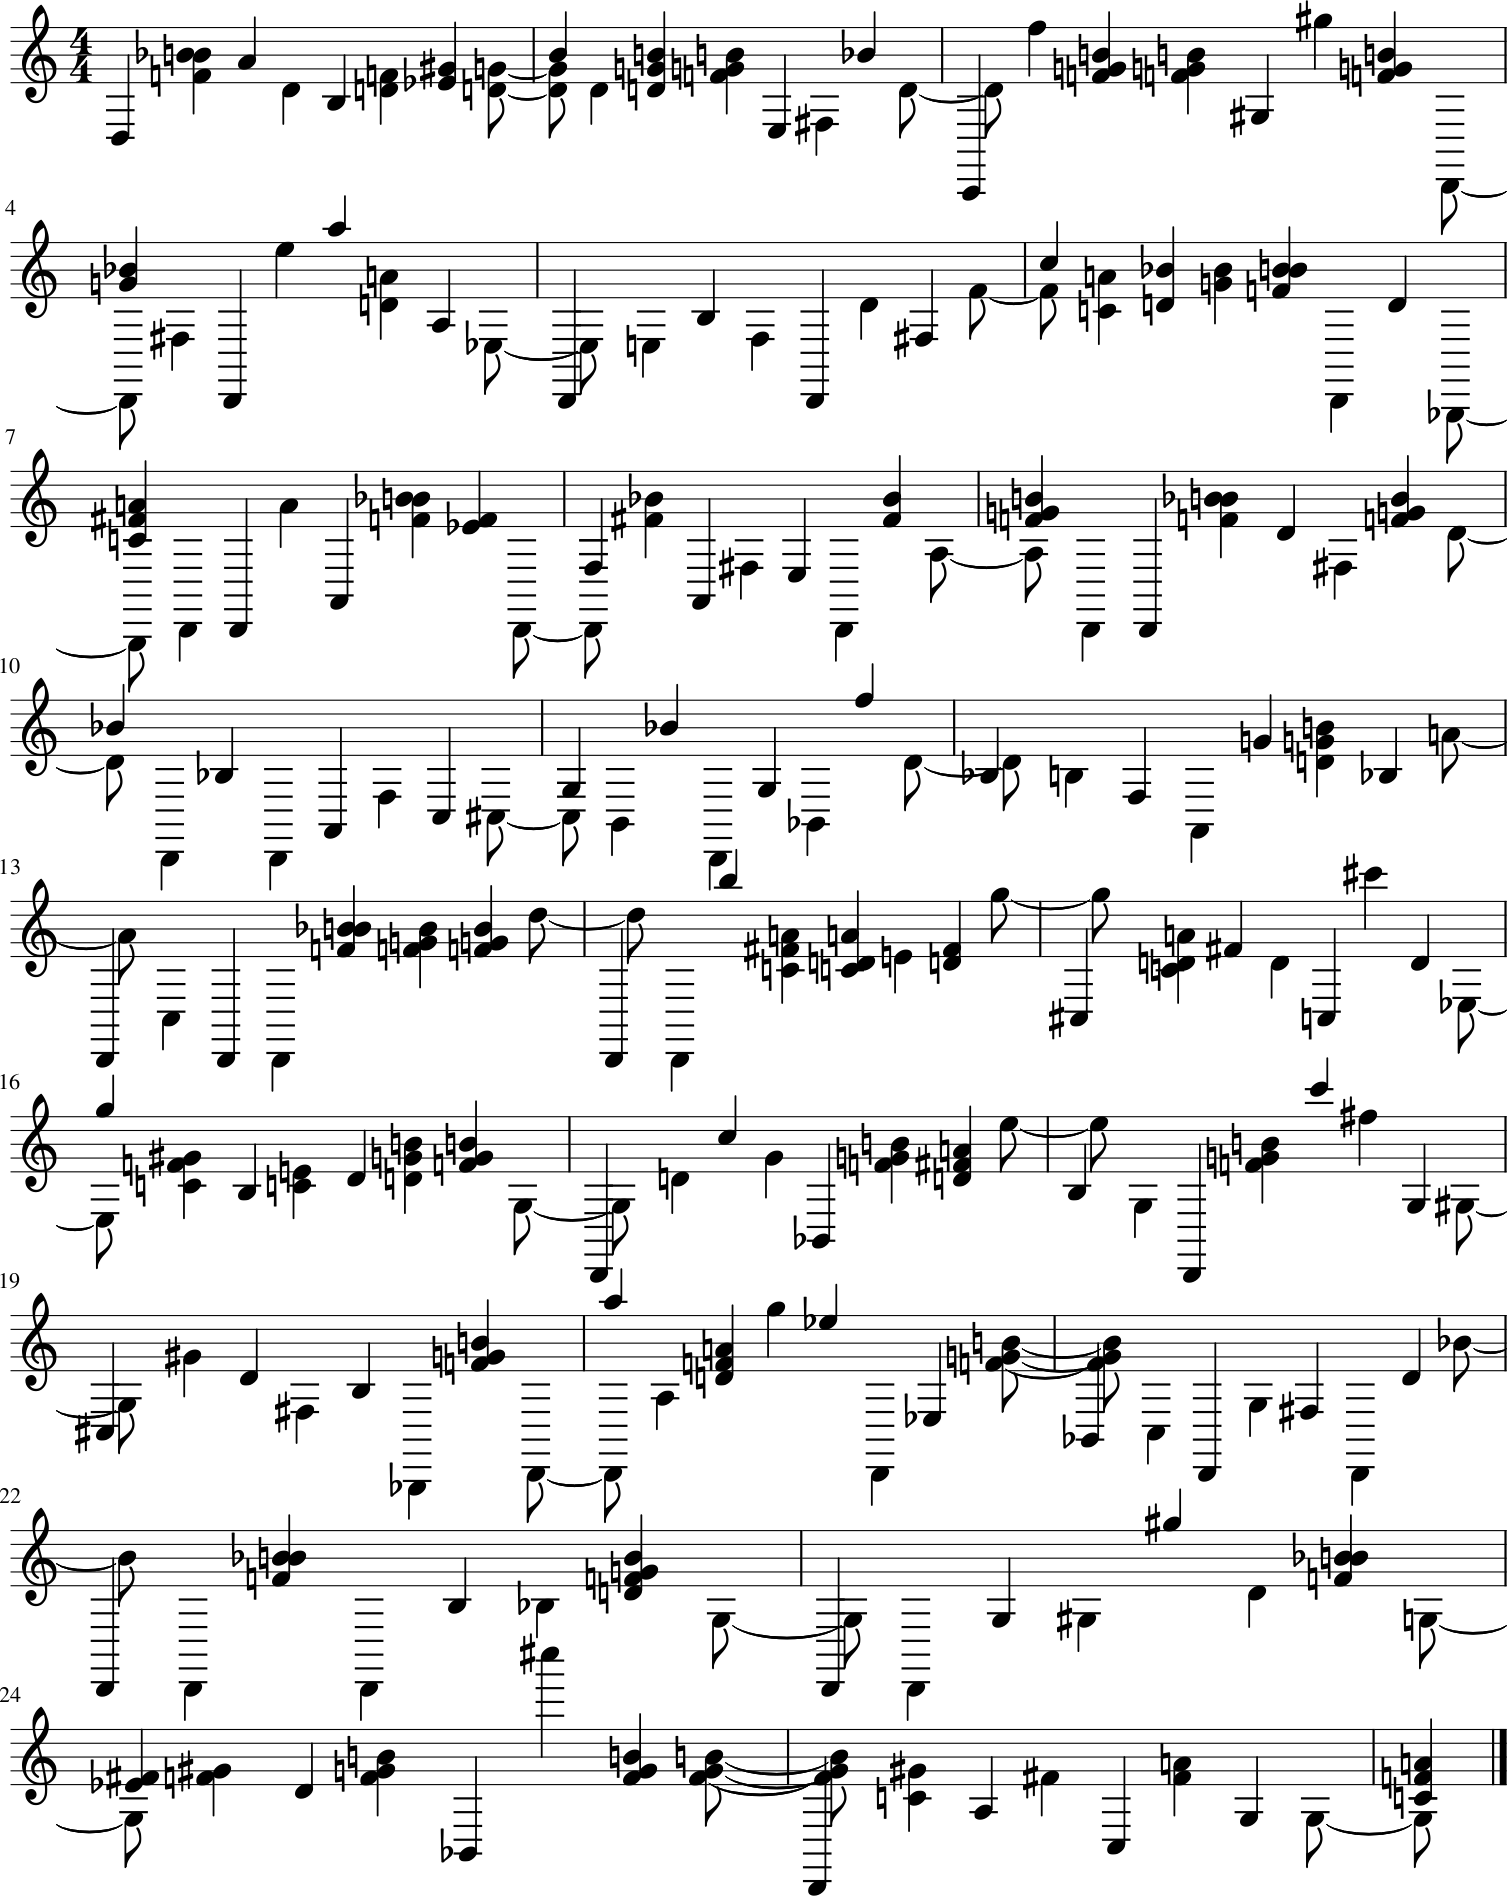

In [20]:
midi_stream.show()